# Projeto: Credit Score Model

## Bibliotecas

In [4]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import inflection
from sklearn.datasets import make_classification
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import RandomizedSearchCV
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score 

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.preprocessing import LabelEncoder
from scipy.stats import ks_2samp
import joblib
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix

import missingno as msno  
from boruta import BorutaPy
from imblearn.pipeline import make_pipeline

from sklearn.preprocessing import OrdinalEncoder

import xgboost as xgb
import shap
pd.set_option('display.max_columns', None)

import jupyterthemes as jt 
from jupyterthemes import jtplot  
jtplot.style(theme='monokai')

### Funções Auxiliares

In [5]:
def distribuicao_2(dataframe, variavel, same_scale = True):
    data_wide = dataframe.pivot(columns='target',
                         values=variavel)
    if same_scale == False:
        data_wide[0] = np.log(1 + data_wide[0])
        data_wide[1] = np.log(1 + data_wide[1])
    else:
        pass
        
    data_wide.plot.density(figsize = (15, 7),
                           linewidth = 2)
    if same_scale == False:
        plt.xlabel(variavel+' (em escala logaritimca)')
    else:
        plt.xlabel(variavel)
    lista1 = dataframe.groupby('target')[variavel].describe().round(2).values.tolist()
    lista2 = [list(dataframe.groupby('target')[variavel].describe().round(2).transpose().index)]
    lista3 = [['Não Target', 'Target']] + lista2 + lista1

    #statistics = print(dataframe.groupby('target')[variavel].describe().round(2).transpose().to_string(justify='right'))
    plt.figtext(0.73,0.73, '  '.join(map(str,lista3[0])), {'multialignment':'right'}, fontsize = 12)
    plt.figtext(0.729,0.73, '___________________', {'multialignment':'right'}, fontsize = 12)
    plt.figtext(0.67,0.48, '\n'.join(map(str, lista3[1])), {'multialignment':'left'}, fontsize = 12)
    plt.figtext(0.75,0.48, '\n'.join(map(str,lista3[2])) , {'multialignment':'right'}, fontsize = 12)
    plt.figtext(0.83,0.48, '\n'.join(map(str,lista3[3])) , {'multialignment':'right'}, fontsize = 12)
    plt.show()

#### Funções Pipe

In [6]:
def remover_colunas_com_nulos(df, limite_porcentagem_nulos=40):
    """
    Remove colunas com mais de 30% de valores nulos
    """
    porcentagem_nulos = (df.isnull().sum() / len(df)) * 100
    colunas_a_remover = porcentagem_nulos[porcentagem_nulos > limite_porcentagem_nulos].index.tolist()
    df = df.drop(columns=colunas_a_remover)
    return df

def calcular_porcentagem_de_nulos(df):
    """
    Calcula a porcentagem de valores nulos
    """
    perc_nulos = (df.isnull().sum() / len(df)) * 100
    perc_nulos_df = pd.DataFrame({'Coluna': perc_nulos.index, '% de Nulos': perc_nulos.values})
    perc_nulos_df = perc_nulos_df.sort_values(by='% de Nulos', ascending=False)
    return perc_nulos_df

def imputar_valores_nulos(df, colunas, estrategias):    
    for coluna, estrategia in zip(colunas, estrategias):
        if estrategia == 'media':
            imputer = SimpleImputer(strategy='mean')
        elif estrategia == 'moda':
            imputer = SimpleImputer(strategy='most_frequent')
        
        df[coluna] = imputer.fit_transform(df[[coluna]])
        
        
def preencher_nulos_com_outro(df, colunas_a_preencher):
    """
    Preenche os valores nulos com 'Outro'
    """
    for coluna in colunas_a_preencher:
        df[coluna].fillna('Outro', inplace=True)

def imputar_valores_nulos_geral(df):    
    for coluna in df.columns:
        if df[coluna].dtype == 'object':  
            imputer = SimpleImputer(strategy='most_frequent')
        else:
            imputer = SimpleImputer(strategy='mean')
        
        if df[coluna].isnull().any():
            df[coluna] = imputer.fit_transform(df[[coluna]])
            
            
def remove_outliers_iqr(df, threshold=1.5):
    """
    Remove outliers de um DataFrame com base no método IQR (Interquartile Range)

    """
    # Identificar colunas numéricas (excluindo 'ID' e 'IDADE')
    features_numericas = df.select_dtypes(include=['int64', 'float64']).columns.difference(['ID', 'IDADE','TARGET'])

    # Criar uma cópia do DataFrame para preservar o original
    df_no_outliers = df.copy()

    # Remover outliers nas colunas numéricas
    for feature in features_numericas:
        Q1 = df_no_outliers[feature].quantile(0.25)
        Q3 = df_no_outliers[feature].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR

        df_no_outliers = df_no_outliers[(df_no_outliers[feature] >= lower_bound) & (df_no_outliers[feature] <= upper_bound)]

    return df_no_outliers


### Carregando os Dados

In [7]:
data = pd.read_csv('data_base/train.csv')
data_teste = pd.read_csv('data_base/test.csv')

## Descrição dos Dados

In [8]:
print("O conjunto de dado de treinamento total tem a dimensão {}". format(data.shape))
print("O conjunto de dado de teste total tem a dimensão {}". format(data_teste.shape)) 

O conjunto de dado de treinamet total tem a dimensão (144469, 151)
O conjunto de dado de teste total tem a dimensão (71157, 151)


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144469 entries, 0 to 144468
Columns: 151 entries, REF_DATE to ID
dtypes: float64(34), int64(3), object(114)
memory usage: 166.4+ MB


In [10]:
data.shape 

(144469, 151)

In [11]:
#data['REF_DATE'] = pd.to_datetime(data['REF_DATE'], format='%Y/%m/%d')

data['VAR46'].isnull().sum()

144106

In [206]:
data.head()
#data.iloc[:,13:].sample(10)

,REF_DATE,TARGET,VAR2,IDADE,VAR4,VAR5,VAR6,VAR7,VAR8,VAR9,VAR10,VAR11,VAR12,VAR13,VAR14,VAR15,VAR16,VAR17,VAR18,VAR19,VAR20,VAR21,VAR22,VAR23,VAR24,VAR25,VAR26,VAR27,VAR28,VAR29,VAR30,VAR31,VAR32,VAR33,VAR34,VAR35,VAR36,VAR37,VAR38,VAR39,VAR40,VAR41,VAR42,VAR43,VAR44,VAR45,VAR46,VAR47,VAR48,VAR49,VAR50,VAR51,VAR52,VAR53,VAR54,VAR55,VAR56,VAR57,VAR58,VAR59,VAR60,VAR61,VAR62,VAR63,VAR64,VAR65,VAR66,VAR67,VAR68,VAR69,VAR70,VAR71,VAR72,VAR73,VAR74,VAR75,VAR76,VAR77,VAR78,VAR79,VAR80,VAR81,VAR82,VAR83,VAR84,VAR85,VAR86,VAR87,VAR88,VAR89,VAR90,VAR91,VAR92,VAR93,VAR94,VAR95,VAR96,VAR97,VAR98,VAR99,VAR100,VAR101,VAR102,VAR103,VAR104,VAR105,VAR106,VAR107,VAR108,VAR109,VAR110,VAR111,VAR112,VAR113,VAR114,VAR115,VAR116,VAR117,VAR118,VAR119,VAR120,VAR121,VAR122,VAR123,VAR124,VAR125,VAR126,VAR127,VAR128,VAR129,VAR130,VAR131,VAR132,VAR133,VAR134,VAR135,VAR136,VAR137,VAR138,VAR139,VAR140,VAR141,VAR142,VAR143,VAR144,VAR145,VAR146,VAR147,VAR148,VAR149,ID
0,2017-01-25 00:00:00+00:00,1,F,24.471,NaN,SP,-23.549841,-46.959865,E,E,ALTA,0.0,0.095,NaN,0.222,0.192,0.083333,NaN,0.983562,2.200000,NaN,NaN,0.125,NaN,0.017,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.378548,0.451697,0.438720,0.499008,NaN,NaN,NaN,NaN,1.000,NaN,S,N,N,N,N,S,N,N,N,N,N,S,S,N,N,N,N,MEDIA,ALTA,MEDIA,ALTA,MEDIA,MEDIA,ALTA,ALTA,ALTA,MEDIA,ALTA,ALTA,MEDIA,ALTA,MEDIA,MEDIA,ALTA,ALTA,ALTA,ALTA,MEDIA,MEDIA,MEDIA,ALTA,BAIXISSIMA,MEDIA,MEDIA,ALTA,ALTA,ALTA,MEDIA,ALTA,ALTA,MEDIA,ALTISSIMA,MEDIA,LONGE,MEDIO,LONGE,LONGE,LONGE,MEDIO,LONGE,PROXIMO,MEDIO,MEDIO,LONGE,MEDIO,MEDIO,LONGE,LONGE,MEDIO,MEDIO,LONGE,MUITO LONGE,MEDIO,LONGE,LONGE,LONGE,MEDIO,MEDIO,MEDIO,LONGE,LONGE,MEDIO,LONGE,MEDIO,MEDIO,MEDIO,LONGE,PROXIMO,LONGE,MEDIO,LONGE,MEDIO,1399.037809,E,NaN,NaN,NaN,NaN,102,EMAIL INEXISTENTE,2.6.1,280764
1,2017-04-03 00:00:00+00:00,1,F,35.041,NaN,BA,-12.924251,-38.487840,E,E,ALTA,0.0,0.005,NaN,0.120,NaN,0.166667,NaN,1.101370,NaN,NaN,NaN,NaN,NaN,0.017,NaN,NaN,NaN,0.0,NaN,0.063,NaN,NaN,NaN,NaN,S,S,198.0,NaN,0.476678,0.401271,0.393429,0.508360,NaN,NaN,NaN,NaN,0.000,NaN,S,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,ALTA,BAIXISSIMA,ALTISSIMA,ALTA,ALTISSIMA,ALTA,ALTA,ALTA,ALTISSIMA,ALTISSIMA,ALTISSIMA,MEDIA,ALTISSIMA,ALTISSIMA,ALTA,ALTA,ALTISSIMA,ALTA,ALTISSIMA,ALTISSIMA,ALTA,ALTA,ALTISSIMA,ALTA,ALTISSIMA,ALTISSIMA,ALTISSIMA,BAIXISSIMA,ALTISSIMA,ALTA,ALTA,ALTA,ALTISSIMA,ALTA,ALTISSIMA,ALTA,MEDIO,MEDIO,PROXIMO,MEDIO,LONGE,LONGE,LONGE,PROXIMO,MEDIO,PROXIMO,MEDIO,MEDIO,MEDIO,PROXIMO,MEDIO,PROXIMO,MUITO PROXIMO,PROXIMO,MUITO LONGE,PROXIMO,MEDIO,MEDIO,MEDIO,MEDIO,LONGE,PROXIMO,MEDIO,PROXIMO,LONGE,PROXIMO,MEDIO,MEDIO,MEDIO,PROXIMO,PROXIMO,MEDIO,MEDIO,MEDIO,MEDIO,1516.196234,E,NaN,NaN,NaN,NaN,102,EMAIL INEXISTENTE,2.6.1,270129
2,2017-07-13 00:00:00+00:00,1,M,63.518,NaN,PI,-5.063743,-42.761499,E,E,MEDIA,0.0,NaN,NaN,0.156,0.117,NaN,NaN,1.446575,1.446575,NaN,NaN,0.125,NaN,0.017,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.532506,0.484427,0.546715,0.480883,NaN,NaN,NaN,NaN,1.000,NaN,S,N,N,N,N,N,N,S,N,N,N,N,N,N,N,N,N,ALTISSIMA,ALTA,ALTA,ALTA,ALTISSIMA,ALTISSIMA,ALTA,BAIXISSIMA,ALTISSIMA,ALTISSIMA,ALTA,ALTA,ALTISSIMA,BAIXISSIMA,ALTISSIMA,ALTISSIMA,ALTA,MEDIA,ALTA,ALTA,BAIXISSIMA,ALTISSIMA,ALTA,ALTISSIMA,ALTISSIMA,ALTA,ALTISSIMA,ALTISSIMA,ALTA,ALTA,ALTISSIMA,MEDIA,ALTISSIMA,ALTISSIMA,ALTISSIMA,ALTISSIMA,LONGE,MEDIO,LONGE,MEDIO,PROXIMO,MEDIO,PROXIMO,MUITO PROXIMO,LONGE,PROXIMO,PROXIMO,MEDIO,LONGE,MUITO LONGE,PROXIMO,LONGE,MEDIO,PROXIMO,MUITO LONGE,LONGE,PROXIMO,MUITO LONGE,MEDIO,PROXIMO,MEDIO,PROXIMO,LONGE,LONGE,MEDIO,PROXIMO,MEDIO,MEDIO,PROXIMO,PROXIMO,PROXIMO,LONGE,MEDIO,MEDIO,MEDIO,1727.153575,E,NaN,NaN,NaN,NaN,102,EMAIL INEXISTENTE,2.6.1,257358
3,2017-01-27 00:00:00+00:00,1,F,47.452,NaN,PA,-0.623754,-47.345800,NaN,E,ALTISSIMA,NaN,NaN,NaN,0.096,0.022,NaN,NaN,0.482192,0.482192,0.011,NaN,0.125,NaN,0.138,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,S,S,227.0,NaN,0.273552,0.533198,0.786395,0.462936,NaN,NaN,NaN,NaN,0.000,NaN,S,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,MEDIA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,MEDIA,MEDIA,BAI

In [14]:
teste_copia = data_teste.copy()

### Regra de Negócio

Estipulamos como regras do negócio:
* Determinar Classe 0 - Bom Pagador como classe Positiva, deixar ela como Classe 1.
* Por regras que seguem os Bancos, referente a atuação em empréstimos, onde a idade limite para empréstimos é de 80 anos, nós colocaremos um corte em 90 anos.
* Variáveis que tenham valores nulos a partir de 30%, serán removidas da análise.


In [15]:
print(data.TARGET.value_counts())
print("\nOs Targets no Treinamento representam {:.2f}% do dataset.\n".format((data[data.TARGET == 1].shape[0] / data.shape[0]) * 100))

1    114400
0     30069
Name: TARGET, dtype: int64

Os Targets no Treinamento representam 79.19% do dataset.



#### Definir TARGET = 0 como Classe Positiva (Agora será Classe 1)

In [16]:
#Deixamos sendo 1
#data['TARGET'] = data['TARGET'].apply(lambda x: 0 if x == 1 else 1)
#data_teste['TARGET'] = data_teste['TARGET'].apply(lambda x: 0 if x == 1 else 1)

#### Variável: Idade

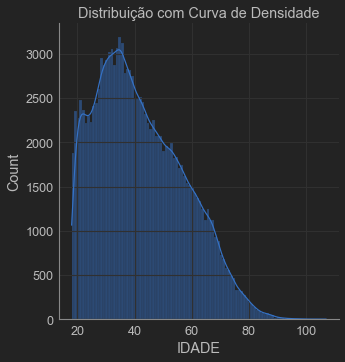

In [17]:
sns.displot(data['IDADE'], kde=True) # "kde=True" adiciona a curva de densidade suavizada
plt.title("Distribuição com Curva de Densidade")
plt.show()

> [!IMPORTANT]
> Por regra de negócio que seguem os bancos, a ideade terá um corte em 90.

In [18]:
data['IDADE'].min()

18.014

In [19]:
out_idade = data.query('IDADE>90')
out_idade

,REF_DATE,TARGET,VAR2,IDADE,VAR4,VAR5,VAR6,VAR7,VAR8,VAR9,VAR10,VAR11,VAR12,VAR13,VAR14,VAR15,VAR16,VAR17,VAR18,VAR19,VAR20,VAR21,VAR22,VAR23,VAR24,VAR25,VAR26,VAR27,VAR28,VAR29,VAR30,VAR31,VAR32,VAR33,VAR34,VAR35,VAR36,VAR37,VAR38,VAR39,VAR40,VAR41,VAR42,VAR43,VAR44,VAR45,VAR46,VAR47,VAR48,VAR49,VAR50,VAR51,VAR52,VAR53,VAR54,VAR55,VAR56,VAR57,VAR58,VAR59,VAR60,VAR61,VAR62,VAR63,VAR64,VAR65,VAR66,VAR67,VAR68,VAR69,VAR70,VAR71,VAR72,VAR73,VAR74,VAR75,VAR76,VAR77,VAR78,VAR79,VAR80,VAR81,VAR82,VAR83,VAR84,VAR85,VAR86,VAR87,VAR88,VAR89,VAR90,VAR91,VAR92,VAR93,VAR94,VAR95,VAR96,VAR97,VAR98,VAR99,VAR100,VAR101,VAR102,VAR103,VAR104,VAR105,VAR106,VAR107,VAR108,VAR109,VAR110,VAR111,VAR112,VAR113,VAR114,VAR115,VAR116,VAR117,VAR118,VAR119,VAR120,VAR121,VAR122,VAR123,VAR124,VAR125,VAR126,VAR127,VAR128,VAR129,VAR130,VAR131,VAR132,VAR133,VAR134,VAR135,VAR136,VAR137,VAR138,VAR139,VAR140,VAR141,VAR142,VAR143,VAR144,VAR145,VAR146,VAR147,VAR148,VAR149,ID
926,2017-04-07 00:00:00+00:00,1,F,90.948,NaN,MG,-16.323983,-43.715446,NaN,E,ALTA,NaN,NaN,NaN,0.121,NaN,NaN,NaN,1.435616,NaN,NaN,NaN,NaN,NaN,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.683582,0.592728,0.834915,0.452756,NaN,NaN,NaN,NaN,1.000,NaN,S,N,N,N,N,N,N,N,N,N,N,N,N,N,S,S,N,MEDIA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,MEDIA,BAIXA,BAIXISSIMA,BAIXISSIMA,MEDIA,BAIXISSIMA,MEDIA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,MEDIA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,MEDIA,BAIXA,BAIXA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,MEDIA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXA,MEDIA,BAIXISSIMA,MEDIA,BAIXISSIMA,BAIXISSIMA,MUITO LONGE,PROXIMO,MUITO LONGE,MUITO LONGE,LONGE,MUITO LONGE,LONGE,MUITO LONGE,MUITO LONGE,MEDIO,MUITO LONGE,PROXIMO,MUITO LONGE,MUITO LONGE,MEDIO,PROXIMO,LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,PROXIMO,MEDIO,MEDIO,MUITO LONGE,MUITO LONGE,MUITO LONGE,PROXIMO,MUITO LONGE,MUITO LONGE,LONGE,PROXIMO,MUITO LONGE,MEDIO,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,2133.992676,D,NaN,NaN,NaN,NaN,102,EMAIL INEXISTENTE,2.6.1,241326
1311,2017-08-24 00:00:00+00:00,1,F,93.586,NaN,GO,-13.530850,-48.221014,NaN,E,ALTISSIMA,NaN,NaN,NaN,0.171,NaN,NaN,NaN,1.816438,NaN,NaN,NaN,NaN,NaN,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.678489,0.541277,0.939665,0.605953,NaN,NaN,NaN,NaN,1.000,NaN,S,N,N,N,N,N,N,N,N,N,N,N,N,N,S,S,N,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,LONGE,MUITO LONGE,MUITO LONGE,LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MEDIO,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,LONGE,MUITO PROXIMO,MUITO LONGE,MUITO LONGE,LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,2133.992676,D,NaN,NaN,NaN,NaN,102,EMAIL INEXISTENTE#@#NOME INEXISTENTE#@#CEP INE...,2.6.1,273617
1722,2017-08-16 00:00:00+00:00,1,M,91.359,NaN,ES,-20.951050,-41.345328,NaN,E,ALTISSIMA,NaN,0.000,NaN,0.168,NaN,0.083333,NaN,1.794520,NaN,NaN,NaN,NaN,NaN,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.716229,0.580000,0.599713,0.461910,NaN,NaN,NaN,NaN,0.022,NaN,S,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,MEDIA,MEDIA,BAIXISSIMA,MEDIA,MEDIA,BAIXISSIMA,ALTA,MEDIA,MEDIA,MEDIA,BAIXISSIMA,MEDIA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,MEDIA,MEDIA,MEDIA,MEDIA,BAIXISSIMA,MEDIA,MEDIA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,MEDIA,MEDIA,MEDIA,MEDIA,BAIXISSIMA,BAIXISSIMA,MUITO LONGE,MEDIO,LONGE,LONGE,MUITO LONGE,MUITO LONGE,LONGE,MUITO LONGE,PROXIMO,LONGE,MUITO LONGE,PROXIMO,PROXIMO,MEDIO,LONGE,MUITO LO

In [20]:
out_idade['TARGET'].value_counts()

1    69
0    22
Name: TARGET, dtype: int64

In [21]:
### A PRINCIPIO NAO APLICAREI A REGRA DE NEGÓCIOS

data = data.query('IDADE< 91')
data_teste = data_teste.query('IDADE< 91')

In [22]:
print("O conjunto de dado de treinamento tem a dimensão {}". format(data.shape))
print("O conjunto de dado de teste tem a dimensão {}". format(data_teste.shape))

O conjunto de dado de treinamento tem a dimensão (127840, 151)
O conjunto de dado de teste tem a dimensão (63099, 151)


### Dimensão dos Dados

In [23]:
print(data.TARGET.value_counts())
print("\nOs Targets no Treinamento representam {:.2f}% do dataset.\n".format((data[data.TARGET == 1].shape[0] / data.shape[0]) * 100))

1    102761
0     25079
Name: TARGET, dtype: int64

Os Targets no Treinamento representam 80.38% do dataset.



In [24]:
print(data_teste.TARGET.value_counts())
print("\nOs Targets no Teste representam {:.2f}% do dataset.\n".format((data_teste[data_teste.TARGET == 1].shape[0] / data_teste.shape[0]) * 100))

1    50737
0    12362
Name: TARGET, dtype: int64

Os Targets no Teste representam 80.41% do dataset.



### Tipo dos Dados

In [25]:
data['REF_DATE'] = pd.to_datetime(data['REF_DATE'])
data_teste['REF_DATE'] = pd.to_datetime(data_teste['REF_DATE'])
data.dtypes 

REF_DATE    datetime64[ns, UTC]
TARGET                    int64
VAR2                     object
IDADE                   float64
VAR4                     object
                   ...         
VAR146                  float64
VAR147                    int64
VAR148                   object
VAR149                   object
ID                        int64
Length: 151, dtype: object

### Dados Ausentes

In [26]:
df = data.copy()
dftes = data_teste.copy()

In [27]:
df_info = calcular_porcentagem_de_nulos(df)
df_info

,Coluna,% de Nulos
146,VAR146,99.852941
4,VAR4,99.801314
46,VAR46,99.723874
45,VAR45,99.723874
44,VAR44,99.647997
...,...,...
1,TARGET,0.000000
47,VAR47,0.000000
39,VAR39,0.000000
3,IDADE,0.000000


#### Aplicando 2da Regra de Negócio ( nulos < 40%)

In [28]:

df = remover_colunas_com_nulos(df)
dftes = remover_colunas_com_nulos(dftes)

In [29]:
print(df.shape)
print(dftes.shape)
print("A base de Treinamento agora tem a dimensão {}". format(df.shape))
print("\nA base de Teste agora tem a dimensão {}".format(dftes.shape))

(127840, 117)
(63099, 117)
A base de Treinamento agora tem a dimensão (127840, 117)

A base de Teste agora tem a dimensão (63099, 117)


In [30]:
df_info1 = calcular_porcentagem_de_nulos(df)
df_info1

,Coluna,% de Nulos
7,VAR8,36.679443
10,VAR11,35.930851
11,VAR14,15.745463
12,VAR18,15.745463
13,VAR24,13.897841
...,...,...
1,TARGET,0.000000
18,VAR47,0.000000
14,VAR39,0.000000
3,IDADE,0.000000


#### Remoção de Outliers

In [31]:
import pandas as pd

def tratamento_outliers_maiores(df, colunas, k=1.5):
    for coluna in colunas:
        # Calcule Q1 e Q3
        Q1 = df[coluna].quantile(0.25)
        Q3 = df[coluna].quantile(0.75)
        # Calcule os limites superior e inferior
        LI = Q1 - k * (Q3 - Q1)
        LS = Q3 + k * (Q3 - Q1)
        # Identifique os outliers
        outliers = df[(df[coluna] < LI) | (df[coluna] > LS)]
        # Substitua os outliers pelo valor máximo da coluna que não seja outlier
        max_sem_outlier = df[(df[coluna] >= LI) & (df[coluna] <= LS)][coluna].max()
        df.loc[outliers.index, coluna] = max_sem_outlier
    return df

# Lista das colunas que deseja aplicar o tratamento de outliers
colunas_para_tratar = ['VAR14', 'VAR24', 'VAR39', 'VAR40', 'VAR42']

# Aplique a função aos seus dados
df = tratamento_outliers_maiores(df, colunas_para_tratar)


In [32]:
# Aplique a função aos seus dados de teste
dftes = tratamento_outliers_maiores(dftes, colunas_para_tratar)

In [33]:
# Agora tiramos os outliers geral de todo o conjunto de dados
df_sem_outliers = remove_outliers_iqr(df)
dftes_sem_outliers = remove_outliers_iqr(dftes) 

In [34]:
print(df_sem_outliers.shape), print(dftes_sem_outliers.shape)

(31959, 117)
(16221, 117)


(None, None)

In [35]:
print(df.shape), print(dftes.shape)

(127840, 117)
(63099, 117)


(None, None)

### Preenchendo valores vazios

In [36]:
df_info3 = calcular_porcentagem_de_nulos(df)
df_info3 

,Coluna,% de Nulos
7,VAR8,36.679443
10,VAR11,35.930851
11,VAR14,15.745463
12,VAR18,15.745463
13,VAR24,13.897841
...,...,...
1,TARGET,0.000000
18,VAR47,0.000000
14,VAR39,0.000000
3,IDADE,0.000000


#### Imputações com Media e Moda

Se os dados são numéricos imputaremos com a Média.<br>
Se os dados são categóricos imputaremos com a Moda.

In [37]:
# CRIAREI UMA CATEGORIA OUTROS PARA AS CATEGORICAS E PARA AS NUMERICAS BOTAREI UMA VALOR DE -50

colunas_categoricas = df.select_dtypes(include=['object']).columns
colunas_numericas = df.select_dtypes(exclude=['object']).columns

colunas_categoricas_tes = dftes.select_dtypes(include=['object']).columns
colunas_numericas_tes = dftes.select_dtypes(exclude=['object']).columns

In [38]:
# Preencher valores nulos nas colunas categóricas com "OUTROS"
df[colunas_categoricas] = df[colunas_categoricas].fillna('OUTROS')
#df[colunas_numericas] = df[colunas_numericas].fillna(-200)

dftes[colunas_categoricas] = dftes[colunas_categoricas_tes].fillna('OUTROS')
#dftes[colunas_numericas] = dftes[colunas_numericas_tes].fillna(-200)


In [39]:

colunas_a_preencher = ['VAR2', 'VAR49', 'VAR50', 'VAR51', 'VAR52', 'VAR53', 'VAR54', 'VAR55', 'VAR56', 'VAR57', 'VAR58', 'VAR59', 'VAR60', 'VAR61', 'VAR62', 'VAR63', 'VAR64', 'VAR65', 'VAR5']
preencher_nulos_com_outro(df, colunas_a_preencher)
preencher_nulos_com_outro(dftes, colunas_a_preencher)

imputar_valores_nulos(df, colunas=['IDADE','VAR40','VAR9','VAR10','VAR14','VAR6','VAR7', 'VAR14', 'VAR18', 'VAR24', 'VAR39', 'VAR140', 'VAR84', 'VAR85', 'VAR87', 'VAR142', 'VAR114', 'VAR109', 'VAR115', 'VAR134', 'VAR135', 'VAR82', 'VAR86', 'VAR88', 'VAR42'], 
                      estrategias=['media','moda','moda','moda','media','moda','moda', 'media', 'media', 'media', 'media', 'moda', 'moda', 'moda', 'moda', 'moda', 'moda', 'moda', 'moda', 'moda', 'moda', 'moda', 'moda', 'moda','media'])
imputar_valores_nulos(dftes, colunas=['IDADE','VAR40','VAR9','VAR10','VAR14','VAR6','VAR7', 'VAR14', 'VAR18', 'VAR24', 'VAR39', 'VAR140', 'VAR84', 'VAR85', 'VAR87', 'VAR142', 'VAR114', 'VAR109', 'VAR115', 'VAR134', 'VAR135', 'VAR82', 'VAR86', 'VAR88', 'VAR42'], 
                      estrategias=['media','moda','moda','moda','media','moda','moda', 'media', 'media', 'media', 'media', 'moda', 'moda', 'moda', 'moda', 'moda', 'moda', 'moda', 'moda', 'moda', 'moda', 'moda', 'moda', 'moda','media'])

imputar_valores_nulos_geral(df)
imputar_valores_nulos_geral(dftes)

df_info2 = calcular_porcentagem_de_nulos(df)
df_info4 = calcular_porcentagem_de_nulos(dftes)


In [40]:
## Verificação final 
df_info2 = calcular_porcentagem_de_nulos(df)
df_info4 = calcular_porcentagem_de_nulos(dftes)

df_info2

,Coluna,% de Nulos
0,REF_DATE,0.0
74,VAR104,0.0
86,VAR116,0.0
85,VAR115,0.0
84,VAR114,0.0
...,...,...
35,VAR65,0.0
34,VAR64,0.0
33,VAR63,0.0
32,VAR62,0.0


In [41]:
df.head(2)

,REF_DATE,TARGET,VAR2,IDADE,VAR5,VAR6,VAR7,VAR8,VAR9,VAR10,VAR11,VAR14,VAR18,VAR24,VAR39,VAR40,VAR41,VAR42,VAR47,VAR49,VAR50,VAR51,VAR52,VAR53,VAR54,VAR55,VAR56,VAR57,VAR58,VAR59,VAR60,VAR61,VAR62,VAR63,VAR64,VAR65,VAR66,VAR67,VAR68,VAR69,VAR70,VAR71,VAR72,VAR73,VAR74,VAR75,VAR76,VAR77,VAR78,VAR79,VAR80,VAR81,VAR82,VAR83,VAR84,VAR85,VAR86,VAR87,VAR88,VAR89,VAR90,VAR91,VAR92,VAR93,VAR94,VAR95,VAR96,VAR97,VAR98,VAR99,VAR100,VAR101,VAR102,VAR103,VAR104,VAR105,VAR106,VAR107,VAR108,VAR109,VAR110,VAR111,VAR112,VAR113,VAR114,VAR115,VAR116,VAR117,VAR118,VAR119,VAR120,VAR121,VAR122,VAR123,VAR124,VAR125,VAR126,VAR127,VAR128,VAR129,VAR130,VAR131,VAR132,VAR133,VAR134,VAR135,VAR136,VAR137,VAR138,VAR139,VAR140,VAR141,VAR142,VAR147,VAR148,VAR149,ID
0,2017-01-25 00:00:00+00:00,1,F,24.471,SP,-23.549841,-46.959865,E,E,ALTA,0.0,0.222,0.983562,0.017,0.378548,0.451697,0.438720,0.499008,1.0,S,N,N,N,N,S,N,N,N,N,N,S,S,N,N,N,N,MEDIA,ALTA,MEDIA,ALTA,MEDIA,MEDIA,ALTA,ALTA,ALTA,MEDIA,ALTA,ALTA,MEDIA,ALTA,MEDIA,MEDIA,ALTA,ALTA,ALTA,ALTA,MEDIA,MEDIA,MEDIA,ALTA,BAIXISSIMA,MEDIA,MEDIA,ALTA,ALTA,ALTA,MEDIA,ALTA,ALTA,MEDIA,ALTISSIMA,MEDIA,LONGE,MEDIO,LONGE,LONGE,LONGE,MEDIO,LONGE,PROXIMO,MEDIO,MEDIO,LONGE,MEDIO,MEDIO,LONGE,LONGE,MEDIO,MEDIO,LONGE,MUITO LONGE,MEDIO,LONGE,LONGE,LONGE,MEDIO,MEDIO,MEDIO,LONGE,LONGE,MEDIO,LONGE,MEDIO,MEDIO,MEDIO,LONGE,PROXIMO,LONGE,MEDIO,LONGE,MEDIO,1399.037809,E,102,EMAIL INEXISTENTE,2.6.1,280764
1,2017-04-03 00:00:00+00:00,1,F,35.041,BA,-12.924251,-38.487840,E,E,ALTA,0.0,0.120,1.101370,0.017,0.476678,0.401271,0.393429,0.508360,0.0,S,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,ALTA,BAIXISSIMA,ALTISSIMA,ALTA,ALTISSIMA,ALTA,ALTA,ALTA,ALTISSIMA,ALTISSIMA,ALTISSIMA,MEDIA,ALTISSIMA,ALTISSIMA,ALTA,ALTA,ALTISSIMA,ALTA,ALTISSIMA,ALTISSIMA,ALTA,ALTA,ALTISSIMA,ALTA,ALTISSIMA,ALTISSIMA,ALTISSIMA,BAIXISSIMA,ALTISSIMA,ALTA,ALTA,ALTA,ALTISSIMA,ALTA,ALTISSIMA,ALTA,MEDIO,MEDIO,PROXIMO,MEDIO,LONGE,LONGE,LONGE,PROXIMO,MEDIO,PROXIMO,MEDIO,MEDIO,MEDIO,PROXIMO,MEDIO,PROXIMO,MUITO PROXIMO,PROXIMO,MUITO LONGE,PROXIMO,MEDIO,MEDIO,MEDIO,MEDIO,LONGE,PROXIMO,MEDIO,PROXIMO,LONGE,PROXIMO,MEDIO,MEDIO,MEDIO,PROXIMO,PROXIMO,MEDIO,MEDIO,MEDIO,MEDIO,1516.196234,E,102,EMAIL INEXISTENTE,2.6.1,270129


In [42]:
print("\nA base de Treinamento agora tem a dimensão {}". format(df.shape))


A base de Treinamento agora tem a dimensão (127840, 117)


### Remoção de Features Constantes

In [43]:
colunas_constantes = [coluna for coluna in df.columns if df[coluna].nunique() == 1]
df = df.drop(columns=colunas_constantes)

In [44]:
colunas_constantes = [coluna for coluna in dftes.columns if dftes[coluna].nunique() == 1]
dftes = dftes.drop(columns=colunas_constantes)

### Matríz de dados faltante

A Matríz verifica visualmente que resolvimos a situação de dados faltantes ou vazíos.

<AxesSubplot:>

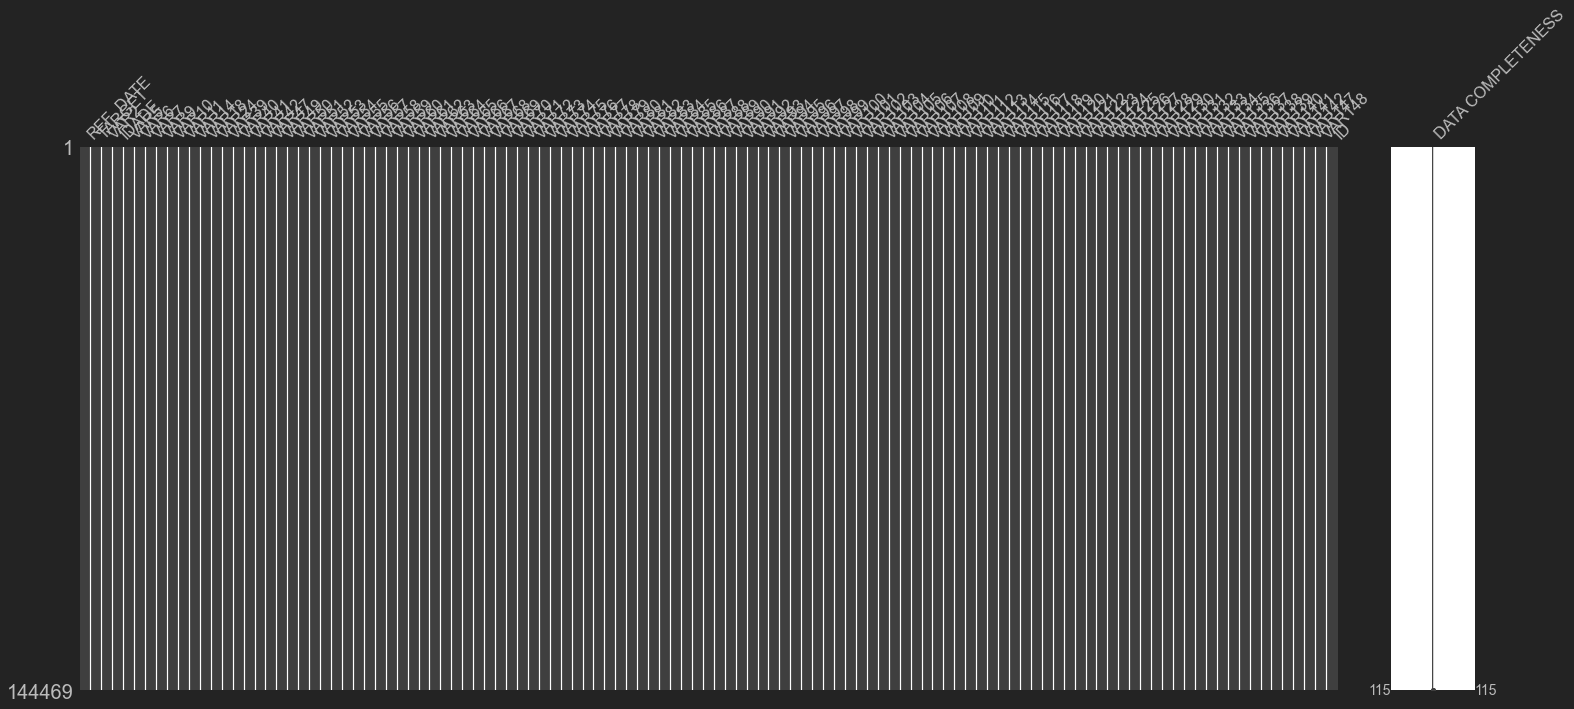

In [45]:
msno.matrix(df, labels=True)  

## Descrição Estatística

In [50]:
num_attributes = df.select_dtypes(include=['int64','float64','int32'])
cat_attributes = df.select_dtypes(exclude=['int64','float64','datetime64[ns]','int32'])

#### Atributos numéricos

In [51]:
# Tendencia Central - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T
# Dispersión - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x:x.max()-x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x:x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x:x.kurtosis())).T

In [52]:
m = pd.concat([d2,d3,ct1,ct2,d1,d5,d6]).T.reset_index()
m.columns=['Attributes','Min','Max','Mean','Median','std','skew','kurtosis']
m

,Attributes,Min,Max,Mean,Median,std,skew,kurtosis
0,TARGET,0.000000,1.000000,0.803825,1.000000,0.397102,-1.530228,0.341604
1,IDADE,18.014000,90.948000,42.097349,39.819000,15.170383,0.479196,-0.552009
2,VAR6,-33.521563,4.478585,-14.935325,-14.865949,9.107631,-0.001635,-1.331609
3,VAR7,-72.900276,-32.429516,-46.076253,-46.702500,7.462701,-0.613500,0.404536
4,VAR11,-4.000000,4.000000,0.244695,0.000000,0.508392,2.973834,15.500688
5,VAR14,0.029000,0.232000,0.133909,0.133909,0.035978,0.618863,1.244596
6,VAR18,0.002740,2.471023,0.986690,0.986690,0.457153,-0.135280,-0.880559
7,VAR24,0.000000,0.207000,0.060357,0.052000,0.063414,1.138065,0.296813
8,VAR39,0.103713,0.844576,0.474666,0.471264,0.136587,-0.044975,-0.462155
9,VAR40,0.249189,0.784665,0.534098,0.511767,0.113424,0.776212,-0.125740


Pontos Importantes:<br>
1. A media da variável IDADE é de 42 aprox. não distando demais das medias das classes quando separadas.
2. A variável VAR141 chega a um máximo de 46 mil aprox, sendo uma média de 2 mil aprox; o que reforça a ideia que seja a representação de uma variável monetária.
3. As outras variáveis não conseguem entregar uma noção do que são por estarem bem encapsuladas.

## Engenharia de Features

Trabalharei a variável REF_DATA, obtendo o dia e a semana em questão.


In [121]:
'''
df['DIA'] = df['REF_DATE'].dt.day
df['SEM'] = df['REF_DATE'].dt.week
dftes['DIA'] = dftes['REF_DATE'].dt.day
dftes['SEM'] = dftes['REF_DATE'].dt.week
'''

"\ndf['DIA'] = df['REF_DATE'].dt.day\ndf['SEM'] = df['REF_DATE'].dt.week\ndftes['DIA'] = dftes['REF_DATE'].dt.day\ndftes['SEM'] = dftes['REF_DATE'].dt.week\n"

#### Transformação por Natureza

Transformação por natureza é uma técnica que tenta capturar o comportamento cíclico da variável, caso ela tenha, é baseado na função de sino e cosino

In [122]:
'''
# Dia
df['DIA_SIN'] = df['DIA'].apply(lambda x: np.sin(x *(2. * np.pi/30)))
df['DIA_COS'] = df['DIA'].apply(lambda x: np.cos(x *(2. * np.pi/30)))
# Semana
df['SEM_SIN'] = df['SEM'].apply(lambda x: np.sin(x *(2. * np.pi/7)))
df['SEM_COS'] = df['SEM'].apply(lambda x: np.cos(x *(2. * np.pi/7)))
# Dia
dftes['DIA_SIN'] = dftes['DIA'].apply(lambda x: np.sin(x *(2. * np.pi/30)))
dftes['DIA_COS'] = dftes['DIA'].apply(lambda x: np.cos(x *(2. * np.pi/30)))
# Semana
dftes['SEM_SIN'] = dftes['SEM'].apply(lambda x: np.sin(x *(2. * np.pi/7)))
dftes['SEM_COS'] = dftes['SEM'].apply(lambda x: np.cos(x *(2. * np.pi/7)))
'''

"\n# Dia\ndf['DIA_SIN'] = df['DIA'].apply(lambda x: np.sin(x *(2. * np.pi/30)))\ndf['DIA_COS'] = df['DIA'].apply(lambda x: np.cos(x *(2. * np.pi/30)))\n# Semana\ndf['SEM_SIN'] = df['SEM'].apply(lambda x: np.sin(x *(2. * np.pi/7)))\ndf['SEM_COS'] = df['SEM'].apply(lambda x: np.cos(x *(2. * np.pi/7)))\n# Dia\ndftes['DIA_SIN'] = dftes['DIA'].apply(lambda x: np.sin(x *(2. * np.pi/30)))\ndftes['DIA_COS'] = dftes['DIA'].apply(lambda x: np.cos(x *(2. * np.pi/30)))\n# Semana\ndftes['SEM_SIN'] = dftes['SEM'].apply(lambda x: np.sin(x *(2. * np.pi/7)))\ndftes['SEM_COS'] = dftes['SEM'].apply(lambda x: np.cos(x *(2. * np.pi/7)))\n"

Guardo os dados de Teste antes de aplicar as transformaçoes nele.

In [53]:
dftes.head()

,REF_DATE,TARGET,VAR2,IDADE,VAR5,VAR6,VAR7,VAR8,VAR9,VAR10,VAR11,VAR14,VAR18,VAR24,VAR39,VAR40,VAR41,VAR42,VAR47,VAR49,VAR50,VAR51,VAR52,VAR53,VAR54,VAR55,VAR56,VAR57,VAR58,VAR59,VAR60,VAR61,VAR62,VAR63,VAR64,VAR65,VAR66,VAR67,VAR68,VAR69,VAR70,VAR71,VAR72,VAR73,VAR74,VAR75,VAR76,VAR77,VAR78,VAR79,VAR80,VAR81,VAR82,VAR83,VAR84,VAR85,VAR86,VAR87,VAR88,VAR89,VAR90,VAR91,VAR92,VAR93,VAR94,VAR95,VAR96,VAR97,VAR98,VAR99,VAR100,VAR101,VAR102,VAR103,VAR104,VAR105,VAR106,VAR107,VAR108,VAR109,VAR110,VAR111,VAR112,VAR113,VAR114,VAR115,VAR116,VAR117,VAR118,VAR119,VAR120,VAR121,VAR122,VAR123,VAR124,VAR125,VAR126,VAR127,VAR128,VAR129,VAR130,VAR131,VAR132,VAR133,VAR134,VAR135,VAR136,VAR137,VAR138,VAR139,VAR140,VAR141,VAR142,VAR147,VAR148,ID
0,2017-07-12 00:00:00+00:00,1,M,33.145,SP,-22.434379,-46.930944,OUTROS,E,MEDIA,0.242432,0.156000,1.698630,0.000000,0.598485,0.381619,0.430834,0.611050,1.000,S,S,S,S,N,N,S,S,N,N,N,S,S,N,N,N,S,ALTA,ALTA,MEDIA,ALTA,ALTA,ALTA,ALTA,BAIXISSIMA,ALTA,MEDIA,ALTA,MEDIA,ALTA,ALTA,ALTA,ALTA,BAIXISSIMA,ALTA,BAIXISSIMA,ALTA,MEDIA,ALTA,MEDIA,MEDIA,BAIXISSIMA,ALTA,ALTA,BAIXISSIMA,ALTA,ALTA,MEDIA,ALTISSIMA,MEDIA,MEDIA,BAIXISSIMA,MEDIA,LONGE,MEDIO,LONGE,PROXIMO,MEDIO,MEDIO,MEDIO,LONGE,LONGE,MEDIO,LONGE,LONGE,MEDIO,LONGE,LONGE,LONGE,LONGE,MEDIO,MUITO LONGE,LONGE,LONGE,LONGE,LONGE,MEDIO,LONGE,LONGE,MEDIO,MEDIO,LONGE,LONGE,LONGE,PROXIMO,LONGE,MEDIO,MEDIO,LONGE,MEDIO,LONGE,MEDIO,1852.386339,E,102,EMAIL INEXISTENTE,254563
1,2017-07-10 00:00:00+00:00,1,F,37.471,PE,-8.875221,-36.366189,E,E,ALTISSIMA,0.000000,0.155000,1.693151,0.000000,0.535474,0.786296,0.877869,0.568515,0.000,S,S,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,MEDIA,MEDIA,BAIXISSIMA,BAIXISSIMA,MEDIA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,MEDIA,BAIXISSIMA,MEDIA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,MEDIA,BAIXISSIMA,MEDIA,BAIXISSIMA,BAIXA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,MEDIA,MEDIA,BAIXISSIMA,BAIXA,BAIXISSIMA,BAIXISSIMA,LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,LONGE,MUITO LONGE,LONGE,LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,LONGE,LONGE,MUITO LONGE,LONGE,MUITO LONGE,MEDIO,MUITO LONGE,LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,LONGE,LONGE,MUITO LONGE,MUITO LONGE,LONGE,LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,LONGE,LONGE,LONGE,LONGE,MUITO LONGE,1548.109828,E,102,EMAIL INEXISTENTE#@#NOME INEXISTENTE#@#CEP INE...,91799
2,2017-04-01 00:00:00+00:00,1,M,27.827,PA,-4.334255,-49.798835,OUTROS,E,ALTISSIMA,0.242432,0.133997,0.984134,0.060317,0.524659,0.691082,0.964479,0.547769,0.000,S,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,PROXIMO,LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO PROXIMO,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,1570.642421,E,102,EMAIL INEXISTENTE#@#NOME INEXISTENTE#@#CEP INE...,149027
4,2017-07-12 00:00:00+00:00,1,M,23.263,PA,-1.061619,-46.783011,OUTROS,E,ALTISSIMA,0.242432,0.133997,0.984134,0.060317,0.472500,0.418465,0.936108,0.454868,0.054,S,S,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,

In [45]:
copia_df_testes_1 = dftes.copy() 

## Transformação dos Dados

In [45]:
!pip install prince

### Aplicando MCA (para categóricos) VAR49 - VAR65

In [46]:
from prince import MCA
selected_features = dftes[['VAR49','VAR50', 'VAR51', 'VAR52', 'VAR53', 'VAR54', 'VAR55', 
                        'VAR56', 'VAR57', 'VAR58', 'VAR59','VAR60','VAR61','VAR62',
                       'VAR63','VAR64','VAR65']]
# Aplique MCA às 10 features selecionadas 
mca = MCA(n_components=1)  # Especifique o número de componentes principais que você deseja
mca_result = mca.fit_transform(selected_features)

# Adicione a nova coluna "MCA_Combined" de volta ao DataFrame original 'df'
dftes['MCA'] = mca_result

In [47]:
from prince import MCA
selected_features = df[['VAR49','VAR50', 'VAR51', 'VAR52', 'VAR53', 'VAR54', 'VAR55', 
                        'VAR56', 'VAR57', 'VAR58', 'VAR59','VAR60','VAR61','VAR62',
                       'VAR63','VAR64','VAR65']]

# Aplique MCA às 10 features selecionadas
mca = MCA(n_components=1)  # Especifique o número de componentes principais que você deseja
mca_result = mca.fit_transform(selected_features)

# Adicione a nova coluna "MCA_Combined" de volta ao DataFrame original 'df'
df['MCA'] = mca_result

### Aplicando MCA (para categóricos) VAR66 - VAR103

In [48]:
selected_features = df[['VAR10','VAR66','VAR67','VAR68','VAR69','VAR70','VAR71','VAR72','VAR73','VAR74',
                        'VAR75','VAR76','VAR77','VAR78','VAR79','VAR80','VAR81','VAR82','VAR83',
                        'VAR84','VAR85','VAR86','VAR87','VAR88','VAR89','VAR90','VAR91','VAR92',
                        'VAR93','VAR94','VAR95','VAR96','VAR97','VAR98','VAR99','VAR100','VAR101',
                        'VAR102','VAR103']]

# Aplique MCA às 10 features selecionadas
mca = MCA(n_components=1)  # Especifique o número de componentes principais que você deseja
mca_result = mca.fit_transform(selected_features)

# Adicione a nova coluna "MCA_Combined" de volta ao DataFrame original 'df'
df['MCA_2'] = mca_result

In [49]:
selected_features = dftes[['VAR10','VAR66','VAR67','VAR68','VAR69','VAR70','VAR71','VAR72','VAR73','VAR74',
                        'VAR75','VAR76','VAR77','VAR78','VAR79','VAR80','VAR81','VAR82','VAR83',
                        'VAR84','VAR85','VAR86','VAR87','VAR88','VAR89','VAR90','VAR91','VAR92',
                        'VAR93','VAR94','VAR95','VAR96','VAR97','VAR98','VAR99','VAR100','VAR101',
                        'VAR102','VAR103']]

# Aplique MCA às 10 features selecionadas
mca = MCA(n_components=1)  # Especifique o número de componentes principais que você deseja
mca_result = mca.fit_transform(selected_features)

# Adicione a nova coluna "MCA_Combined" de volta ao DataFrame original 'df'
dftes['MCA_2'] = mca_result

### Aplicando MCA (para categóricos) VAR104 - VAR140

In [50]:
selected_features = df[['VAR104','VAR105','VAR106','VAR107','VAR108','VAR109','VAR110','VAR111','VAR112',
                        'VAR113','VAR114','VAR115','VAR116','VAR117','VAR118','VAR119', 'VAR120','VAR121',
                        'VAR122','VAR123', 'VAR124','VAR125','VAR126','VAR127','VAR128','VAR129','VAR130',
                        'VAR131','VAR132', 'VAR133', 'VAR134', 'VAR135', 'VAR136', 'VAR137','VAR138',
                        'VAR139','VAR140']]

# Aplique MCA às 10 features selecionadas
mca = MCA(n_components=1)  # Especifique o número de componentes principais que você deseja
mca_result = mca.fit_transform(selected_features)

# Adicione a nova coluna "MCA_Combined" de volta ao DataFrame original 'df'
df['MCA_3'] = mca_result

In [51]:
selected_features = dftes[['VAR104','VAR105','VAR106','VAR107','VAR108','VAR109','VAR110','VAR111','VAR112',
                        'VAR113','VAR114','VAR115','VAR116','VAR117','VAR118','VAR119', 'VAR120','VAR121',
                        'VAR122','VAR123', 'VAR124','VAR125','VAR126','VAR127','VAR128','VAR129','VAR130',
                        'VAR131','VAR132', 'VAR133', 'VAR134', 'VAR135', 'VAR136', 'VAR137','VAR138',
                        'VAR139','VAR140']]

# Aplique MCA às 10 features selecionadas
mca = MCA(n_components=1)  # Especifique o número de componentes principais que você deseja
mca_result = mca.fit_transform(selected_features)

# Adicione a nova coluna "MCA_Combined" de volta ao DataFrame original 'df'
dftes['MCA_3'] = mca_result

In [52]:
df1 = df.copy()
dftes1 = dftes.copy()

In [53]:
columns_to_remove = ['VAR49','VAR50', 'VAR51', 'VAR52', 'VAR53', 'VAR54', 'VAR55', 
                        'VAR56', 'VAR57', 'VAR58', 'VAR59','VAR60','VAR61','VAR62',
                       'VAR63','VAR64','VAR65']
df1.drop(columns=columns_to_remove, inplace=True)
dftes1.drop(columns=columns_to_remove, inplace=True)

In [54]:
print(df1.shape)
print(dftes1.shape) 

(127840, 102)
(63099, 102)


In [55]:
columns_to_remove = ['VAR10','VAR66','VAR67','VAR68','VAR69','VAR70','VAR71','VAR72','VAR73','VAR74',
                        'VAR75','VAR76','VAR77','VAR78','VAR79','VAR80','VAR81','VAR82','VAR83',
                        'VAR84','VAR85','VAR86','VAR87','VAR88','VAR89','VAR90','VAR91','VAR92',
                        'VAR93','VAR94','VAR95','VAR96','VAR97','VAR98','VAR99','VAR100','VAR101',
                        'VAR102','VAR103']
df1.drop(columns=columns_to_remove, inplace=True)
dftes1.drop(columns=columns_to_remove, inplace=True)

In [56]:
print(df1.shape)
print(dftes1.shape)

(127840, 63)
(63099, 63)


In [57]:
columns_to_remove = ['VAR104','VAR105','VAR106','VAR107','VAR108','VAR109','VAR110','VAR111','VAR112',
                        'VAR113','VAR114','VAR115','VAR116','VAR117','VAR118','VAR119', 'VAR120','VAR121',
                        'VAR122','VAR123', 'VAR124','VAR125','VAR126','VAR127','VAR128','VAR129','VAR130',
                        'VAR131','VAR132', 'VAR133', 'VAR134', 'VAR135', 'VAR136', 'VAR137','VAR138',
                        'VAR139','VAR140']
df1.drop(columns=columns_to_remove, inplace=True)
dftes1.drop(columns=columns_to_remove, inplace=True)

In [58]:
print(df1.shape)
print(dftes1.shape)

(127840, 26)
(63099, 26)


In [59]:
df1.head()

,REF_DATE,TARGET,VAR2,IDADE,VAR5,VAR6,VAR7,VAR8,VAR9,VAR11,VAR14,VAR18,VAR24,VAR39,VAR40,VAR41,VAR42,VAR47,VAR141,VAR142,VAR147,VAR148,ID,MCA,MCA_2,MCA_3
0,2017-01-25 00:00:00+00:00,1,F,24.471,SP,-23.549841,-46.959865,E,E,0.000000,0.222,0.983562,0.017,0.378548,0.451697,0.438720,0.499008,1.000,1399.037809,E,102,EMAIL INEXISTENTE,280764,-0.006851,-0.129765,-0.129389
1,2017-04-03 00:00:00+00:00,1,F,35.041,BA,-12.924251,-38.487840,E,E,0.000000,0.120,1.101370,0.017,0.476678,0.401271,0.393429,0.508360,0.000,1516.196234,E,102,EMAIL INEXISTENTE,270129,-0.006851,-0.130169,-0.129389
2,2017-07-13 00:00:00+00:00,1,M,63.518,PI,-5.063743,-42.761499,E,E,0.000000,0.156,1.446575,0.017,0.532506,0.484427,0.546715,0.480883,1.000,1727.153575,E,102,EMAIL INEXISTENTE,257358,-0.006851,-0.130154,-0.129389
3,2017-01-27 00:00:00+00:00,1,F,47.452,PA,-0.623754,-47.345800,OUTROS,E,0.244695,0.096,0.482192,0.138,0.273552,0.533198,0.786395,0.462936,0.000,1627.157652,E,102,EMAIL INEXISTENTE,264374,-0.006851,-0.129227,-0.129389
4,2017-05-24 00:00:00+00:00,1,F,59.096,RS,-28.460032,-52.820856,OUTROS,E,0.244695,0.138,1.564384,0.000,0.682983,0.770025,0.959874,0.477417,0.503,2133.992676,D,102,EMAIL INEXISTENTE,230273,-0.006851,-0.129261,-0.129389


In [60]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 127840 entries, 0 to 144468
Data columns (total 26 columns):
 #   Column    Non-Null Count   Dtype              
---  ------    --------------   -----              
 0   REF_DATE  127840 non-null  datetime64[ns, UTC]
 1   TARGET    127840 non-null  int64              
 2   VAR2      127840 non-null  object             
 3   IDADE     127840 non-null  float64            
 4   VAR5      127840 non-null  object             
 5   VAR6      127840 non-null  float64            
 6   VAR7      127840 non-null  float64            
 7   VAR8      127840 non-null  object             
 8   VAR9      127840 non-null  object             
 9   VAR11     127840 non-null  float64            
 10  VAR14     127840 non-null  float64            
 11  VAR18     127840 non-null  float64            
 12  VAR24     127840 non-null  float64            
 13  VAR39     127840 non-null  float64            
 14  VAR40     127840 non-null  float64            
 15  

### Aplicando Encoders

Nota: Aplicamos LabelEncoder para converter variável cat em num.

In [61]:
col_le = ['VAR2', 'VAR5', 'VAR9','VAR142', 'VAR148', 'VAR8'           
         ] 
lbl = LabelEncoder()

for coluna in col_le:
    df1[coluna] = lbl.fit_transform(df1[coluna])

for coluna in col_le:
    dftes1[coluna] = lbl.fit_transform(dftes1[coluna])    

Nota: Aplicamos OrdinalEncoders para variáveis com as que SIM nos importamos no ordem.

In [62]:
'''
col_oe = ['VAR66', 'VAR67', 'VAR68', 'VAR69','VAR70','VAR71','VAR72','VAR73','VAR74','VAR75',
          'VAR76', 'VAR77', 'VAR78', 'VAR79','VAR80','VAR81','VAR82','VAR83','VAR84','VAR85',
          'VAR86', 'VAR87', 'VAR88', 'VAR89','VAR90','VAR91','VAR92','VAR93','VAR94','VAR95',
          'VAR96', 'VAR97', 'VAR98', 'VAR99','VAR100','VAR101','VAR102','VAR103','VAR104','VAR105',
          'VAR106', 'VAR107', 'VAR108', 'VAR109','VAR110','VAR111','VAR112','VAR113','VAR114','VAR115',
          'VAR116', 'VAR117', 'VAR118', 'VAR119','VAR120','VAR121','VAR122','VAR123','VAR124','VAR125',
          'VAR126', 'VAR127', 'VAR128', 'VAR129','VAR130','VAR131','VAR132','VAR133','VAR134','VAR135',
          'VAR136', 'VAR137', 'VAR138', 'VAR139','VAR140','VAR111','VAR112','VAR113','VAR114','VAR115'          
          ]
ord = OrdinalEncoder()
for coluna in col_oe:
    df[coluna] = ord.fit_transform(df[coluna].values.reshape(-1, 1))    
for coluna in col_oe:
    dftes[coluna] = ord.fit_transform(dftes[coluna].values.reshape(-1, 1))
'''

"\ncol_oe = ['VAR66', 'VAR67', 'VAR68', 'VAR69','VAR70','VAR71','VAR72','VAR73','VAR74','VAR75',\n          'VAR76', 'VAR77', 'VAR78', 'VAR79','VAR80','VAR81','VAR82','VAR83','VAR84','VAR85',\n          'VAR86', 'VAR87', 'VAR88', 'VAR89','VAR90','VAR91','VAR92','VAR93','VAR94','VAR95',\n          'VAR96', 'VAR97', 'VAR98', 'VAR99','VAR100','VAR101','VAR102','VAR103','VAR104','VAR105',\n          'VAR106', 'VAR107', 'VAR108', 'VAR109','VAR110','VAR111','VAR112','VAR113','VAR114','VAR115',\n          'VAR116', 'VAR117', 'VAR118', 'VAR119','VAR120','VAR121','VAR122','VAR123','VAR124','VAR125',\n          'VAR126', 'VAR127', 'VAR128', 'VAR129','VAR130','VAR131','VAR132','VAR133','VAR134','VAR135',\n          'VAR136', 'VAR137', 'VAR138', 'VAR139','VAR140','VAR111','VAR112','VAR113','VAR114','VAR115'          \n          ]\nord = OrdinalEncoder()\nfor coluna in col_oe:\n    df[coluna] = ord.fit_transform(df[coluna].values.reshape(-1, 1))    \nfor coluna in col_oe:\n    dftes[coluna] = ord.f

In [63]:
# Aplicar dummies à coluna 'Categoria'
#df = pd.get_dummies(df, columns=['VAR34'], drop_first=True)
#df = pd.get_dummies(df, columns=['VAR31'], drop_first=True)

#dftes = pd.get_dummies(dftes, columns=['VAR34'], drop_first=True)
#dftes = pd.get_dummies(dftes, columns=['VAR31'], drop_first=True) 

In [64]:
df1.head(10)

,REF_DATE,TARGET,VAR2,IDADE,VAR5,VAR6,VAR7,VAR8,VAR9,VAR11,VAR14,VAR18,VAR24,VAR39,VAR40,VAR41,VAR42,VAR47,VAR141,VAR142,VAR147,VAR148,ID,MCA,MCA_2,MCA_3
0,2017-01-25 00:00:00+00:00,1,0,24.471,26,-23.549841,-46.959865,4,4,0.000000,0.222000,0.983562,0.017000,0.378548,0.451697,0.438720,0.499008,1.000,1399.037809,4,102,2,280764,-0.006851,-0.129765,-0.129389
1,2017-04-03 00:00:00+00:00,1,0,35.041,4,-12.924251,-38.487840,4,4,0.000000,0.120000,1.101370,0.017000,0.476678,0.401271,0.393429,0.508360,0.000,1516.196234,4,102,2,270129,-0.006851,-0.130169,-0.129389
2,2017-07-13 00:00:00+00:00,1,1,63.518,17,-5.063743,-42.761499,4,4,0.000000,0.156000,1.446575,0.017000,0.532506,0.484427,0.546715,0.480883,1.000,1727.153575,4,102,2,257358,-0.006851,-0.130154,-0.129389
3,2017-01-27 00:00:00+00:00,1,0,47.452,14,-0.623754,-47.345800,5,4,0.244695,0.096000,0.482192,0.138000,0.273552,0.533198,0.786395,0.462936,0.000,1627.157652,4,102,2,264374,-0.006851,-0.129227,-0.129389
4,2017-05-24 00:00:00+00:00,1,0,59.096,23,-28.460032,-52.820856,5,4,0.244695,0.138000,1.564384,0.000000,0.682983,0.770025,0.959874,0.477417,0.503,2133.992676,3,102,2,230273,-0.006851,-0.129261,-0.129389
5,2017-08-05 00:00:00+00:00,1,1,20.181,27,-10.175280,-48.298247,5,4,0.244695,0.133909,0.986690,0.060357,0.462267,0.612457,0.908437,0.558302,1.000,1570.642421,4,102,3,238546,-0.006851,-0.129024,-0.129389
6,2017-08-16 00:00:00+00:00,1,0,25.458,13,-28.296333,-52.793776,4,5,0.244695,0.133909,0.986690,0.060357,0.478202,0.784665,0.629786,0.508360,0.000,1344.866459,4,102,3,77214,-0.006851,7.713928,7.728622
7,2017-08-16 00:00:00+00:00,0,0,42.589,6,-16.019765,-48.058090,4,4,0.000000,0.232000,0.503899,0.207000,0.508042,0.396883,0.346575,0.559399,0.015,1297.790000,4,100,5,303292,-0.006851,-0.129763,-0.129389
8,2017-04-07 00:00:00+00:00,1,0,22.800,21,-12.695583,-60.153704,5,3,0.244695,0.133909,0.986690,0.060357,0.491698,0.481123,0.487452,0.463579,0.001,1395.112031,4,102,3,1376,-0.006851,-0.129644,-0.129389
9,2017-03-11 00:00:00+00:00,1,1,22.299,5,-3.863074,-38.509331,4,4,0.000000,0.069000,1.038356,0.017000,0.268816,0.432927,0.401938,0.508360,0.000,1560.669227,4,102,3,46733,-0.006851,-0.129832,-0.129389


In [65]:
df1['MCA'].max()

145.96460758234056

In [66]:
df1['MCA_3'].max()

7.7286215749596

#### Gráfico de Correlação

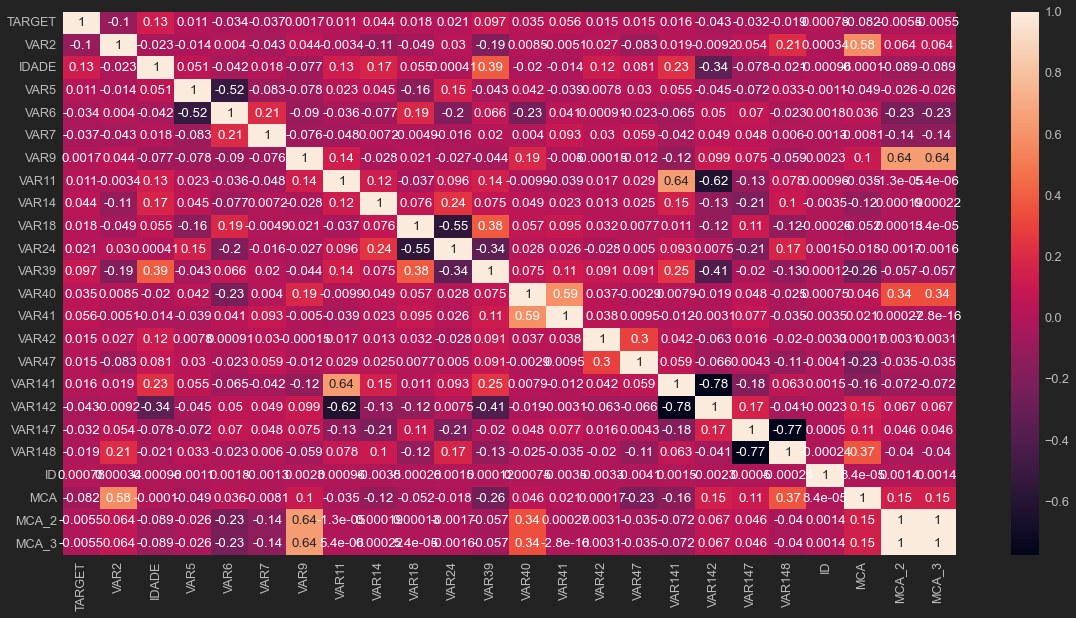

In [243]:
fig = plt.figure(figsize =(20, 10))
#correlation = num_attributes.corr(method='pearson')
correlation = df1.corr(method='pearson')
sns.heatmap(correlation,annot=True);

Mostramos a correlação de variáveis numéricas que tinhas separados para as estatísticas. Percebemos correlações fracas.

### Normalização dos Dados

#### Aplicando Rescaling

Nota: 
* Aplicaremos RobustScaler para dados sensíveis de outliers. <br>
* Aplicaremos MinMaxScaler para dados de menor escala.

In [67]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 127840 entries, 0 to 144468
Data columns (total 26 columns):
 #   Column    Non-Null Count   Dtype              
---  ------    --------------   -----              
 0   REF_DATE  127840 non-null  datetime64[ns, UTC]
 1   TARGET    127840 non-null  int64              
 2   VAR2      127840 non-null  int32              
 3   IDADE     127840 non-null  float64            
 4   VAR5      127840 non-null  int32              
 5   VAR6      127840 non-null  float64            
 6   VAR7      127840 non-null  float64            
 7   VAR8      127840 non-null  int32              
 8   VAR9      127840 non-null  int32              
 9   VAR11     127840 non-null  float64            
 10  VAR14     127840 non-null  float64            
 11  VAR18     127840 non-null  float64            
 12  VAR24     127840 non-null  float64            
 13  VAR39     127840 non-null  float64            
 14  VAR40     127840 non-null  float64            
 15  

In [68]:
df1['VAR11'].unique()

array([ 0.        ,  0.24469514,  1.        ,  3.        ,  2.        ,
        4.        , -2.        , -1.        , -3.        , -4.        ])

In [69]:
df1.head()

,REF_DATE,TARGET,VAR2,IDADE,VAR5,VAR6,VAR7,VAR8,VAR9,VAR11,VAR14,VAR18,VAR24,VAR39,VAR40,VAR41,VAR42,VAR47,VAR141,VAR142,VAR147,VAR148,ID,MCA,MCA_2,MCA_3
0,2017-01-25 00:00:00+00:00,1,0,24.471,26,-23.549841,-46.959865,4,4,0.000000,0.222,0.983562,0.017,0.378548,0.451697,0.438720,0.499008,1.000,1399.037809,4,102,2,280764,-0.006851,-0.129765,-0.129389
1,2017-04-03 00:00:00+00:00,1,0,35.041,4,-12.924251,-38.487840,4,4,0.000000,0.120,1.101370,0.017,0.476678,0.401271,0.393429,0.508360,0.000,1516.196234,4,102,2,270129,-0.006851,-0.130169,-0.129389
2,2017-07-13 00:00:00+00:00,1,1,63.518,17,-5.063743,-42.761499,4,4,0.000000,0.156,1.446575,0.017,0.532506,0.484427,0.546715,0.480883,1.000,1727.153575,4,102,2,257358,-0.006851,-0.130154,-0.129389
3,2017-01-27 00:00:00+00:00,1,0,47.452,14,-0.623754,-47.345800,5,4,0.244695,0.096,0.482192,0.138,0.273552,0.533198,0.786395,0.462936,0.000,1627.157652,4,102,2,264374,-0.006851,-0.129227,-0.129389
4,2017-05-24 00:00:00+00:00,1,0,59.096,23,-28.460032,-52.820856,5,4,0.244695,0.138,1.564384,0.000,0.682983,0.770025,0.959874,0.477417,0.503,2133.992676,3,102,2,230273,-0.006851,-0.129261,-0.129389


In [70]:
robust = RobustScaler()
col_rs = ['IDADE', 'VAR6', 'VAR7', 'VAR11', 'VAR18',
          'VAR141', 'VAR147','MCA','MCA_2','MCA_3']
drs = df1[col_rs]
rs = robust.fit_transform(drs)
df1[col_rs] = rs
drs1 = dftes1[col_rs]
rs = robust.fit_transform(drs1)
dftes1[col_rs] = rs 

In [71]:
minmax = MinMaxScaler()
col_rs = ['VAR14','VAR5', 'VAR147']
mms = df1[col_rs]
ms = minmax.fit_transform(mms)
df1[col_rs] = ms
mms1 = dftes1[col_rs]
ms = minmax.fit_transform(mms1)
dftes1[col_rs] = ms 

In [72]:
df1['VAR8'].value_counts()

4    65698
5    46891
3    11022
2     3536
1      500
0      193
Name: VAR8, dtype: int64

In [73]:
porcentagens = df1['VAR8'].value_counts(normalize=True) * 100

print(porcentagens)

4    51.390801
5    36.679443
3     8.621715
2     2.765957
1     0.391114
0     0.150970
Name: VAR8, dtype: float64


In [74]:
df1.sample(10)

,REF_DATE,TARGET,VAR2,IDADE,VAR5,VAR6,VAR7,VAR8,VAR9,VAR11,VAR14,VAR18,VAR24,VAR39,VAR40,VAR41,VAR42,VAR47,VAR141,VAR142,VAR147,VAR148,ID,MCA,MCA_2,MCA_3
123855,2017-08-28 00:00:00+00:00,1,1,-0.296235,0.851852,-1.050939,-0.474029,3,4,4.086718,0.541872,0.609069,0.034000,0.391746,0.536087,0.945092,0.476525,1.000,3.070945,3,1.0,3,47426,1.216645,0.571320,0.833333
14653,2017-05-12 00:00:00+00:00,1,1,-0.204634,0.074074,0.745749,-1.154164,4,4,0.000000,0.517241,0.260768,0.017000,0.530928,0.428594,0.956737,0.450773,1.000,0.113291,4,1.0,2,23355,0.000000,0.628650,0.916667
53984,2017-08-19 00:00:00+00:00,1,0,-0.639118,0.148148,0.294005,0.741956,5,4,1.000000,0.516791,0.000000,0.060357,0.504250,0.508515,0.975461,0.487379,1.000,-0.815412,4,1.0,3,167492,0.000000,0.649490,1.000000
25510,2017-07-12 00:00:00+00:00,1,0,0.228458,0.074074,0.719600,-1.184334,4,4,0.000000,0.625616,0.538119,0.017000,0.429529,0.422064,0.325554,0.553818,1.000,-0.555091,4,1.0,2,135404,-0.320034,-0.317028,-0.583333
34171,2017-04-19 00:00:00+00:00,1,0,-0.399704,0.148148,0.061491,0.589033,4,4,0.000000,0.477833,0.186592,0.017000,0.284347,0.449837,0.496248,0.508360,0.000,-0.383568,4,1.0,3,272329,0.000000,-0.048776,-0.416667
35335,2017-01-05 00:00:00+00:00,1,0,-0.017738,0.148148,0.120083,0.741295,4,4,0.000000,1.000000,0.231743,0.034000,0.439138,0.360955,0.408589,0.475389,0.238,-0.444594,4,1.0,3,69649,0.000000,-0.784651,-0.250000
98089,2017-07-06 00:00:00+00:00,1,0,0.095166,0.851852,-0.930155,-0.550417,5,4,1.000000,0.615764,0.818694,0.000000,0.624661,0.735058,0.823939,0.482978,1.000,0.199240,4,1.0,3,105950,-0.719863,0.034955,0.000000
56671,2017-06-08 00:00:00+00:00,1,0,-0.872837,0.851852,-0.798853,-0.587126,4,4,0.000000,0.516791,0.000000,0.060357,0.416720,0.730539,0.916771,0.455953,0.000,-0.907776,4,1.0,3,109439,0.592021,0.595776,0.166667
59555,2017-07-15 00:00:00+00:00,1,1,0.583036,0.962963,-0.526857,0.026509,4,4,0.000000,0.630542,-0.500333,0.103000,0.259206,0.468946,0.411899,0.509895,0.530,0.324715,4,1.0,3,75159,1.469755,-0.346281,-0.583333
25063,2017-05-03 00:00:00+00:00,1,0,-0.886271,0.666667,-0.645729,-0.425521,5,4,1.000000,0.516791,0.000000,0.060357,0.467885,0.511399,0.460842,0.536657,0.000,-0.852870,4,1.0,3,214229,0.000000,-0.284280,-0.416667


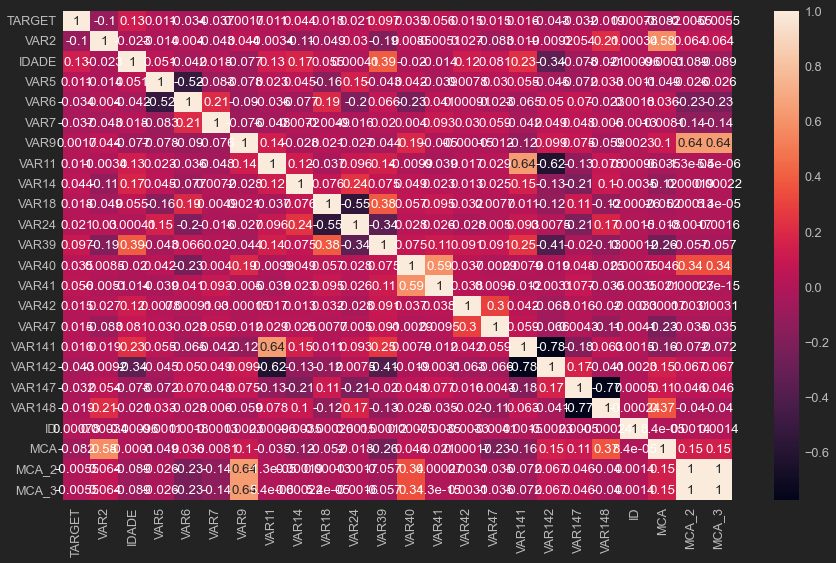

In [152]:
#columns_corr= ['IDADE','VAR39','VAR42','VAR18','VAR14','VAR141','VAR7','VAR6','VAR40',
#                'VAR41','VAR47','VAR24','VAR5']
#columns_corr= ['IDADE','VAR39','VAR42','VAR18','VAR14','VAR141','VAR7','VAR6','VAR40','DIA_COS',
#                'VAR41','DIA_SIN','VAR47','SEM_SIN','VAR24','SEM_COS','VAR5']
df_corr = df1
fig = plt.figure(figsize =(15, 9))
correlation = df_corr.corr(method='pearson')
sns.heatmap(correlation,annot=True);

Guardamos novamente os dataset, desta vez com tratamento.

In [75]:
df_reserva = df1.copy()
df_reservates = dftes1.copy()

In [76]:
df1.shape

(127840, 26)

#### Filtrar Colunas

In [77]:
col_rem = ['REF_DATE','ID']
#col_rem = ['REF_DATE','DIA', 'SEM','ID']
df1 = df1.drop(col_rem, axis=1)
dftes1 = dftes1.drop(col_rem, axis=1)

In [78]:
print(df1.shape)
print(dftes1.shape)

(127840, 24)
(63099, 24)


In [79]:
df1.head(2)

,TARGET,VAR2,IDADE,VAR5,VAR6,VAR7,VAR8,VAR9,VAR11,VAR14,VAR18,VAR24,VAR39,VAR40,VAR41,VAR42,VAR47,VAR141,VAR142,VAR147,VAR148,MCA,MCA_2,MCA_3
0,1,0,-0.667246,0.962963,-0.532226,-0.022855,4,4,0.0,0.950739,-0.003682,0.017,0.378548,0.451697,0.438720,0.499008,1.0,-0.841441,4,1.0,2,2.509653,-0.150253,-0.75
1,1,0,-0.207721,0.148148,0.119004,0.729488,4,4,0.0,0.448276,0.134993,0.017,0.476678,0.401271,0.393429,0.508360,0.0,-0.500343,4,1.0,2,0.000000,-0.586918,0.00


## Seleção de Variáveis

In [80]:
dfx = df1.copy()
dfx_tes = dftes1.copy()

In [81]:
dfx.head(20)

,TARGET,VAR2,IDADE,VAR5,VAR6,VAR7,VAR8,VAR9,VAR11,VAR14,VAR18,VAR24,VAR39,VAR40,VAR41,VAR42,VAR47,VAR141,VAR142,VAR147,VAR148,MCA,MCA_2,MCA_3
0,1,0,-0.667246,0.962963,-0.532226,-0.022855,4,4,0.000000,0.950739,-0.003682,0.017000,0.378548,0.451697,0.438720,0.499008,1.000,-0.841441,4,1.0,2,2.509653,-0.150253,-7.500000e-01
1,1,0,-0.207721,0.148148,0.119004,0.729488,4,4,0.000000,0.448276,0.134993,0.017000,0.476678,0.401271,0.393429,0.508360,0.000,-0.500343,4,1.0,2,0.000000,-0.586918,0.000000e+00
2,1,1,1.030302,0.629630,0.600766,0.349974,4,4,0.000000,0.625616,0.541343,0.017000,0.532506,0.484427,0.546715,0.480883,1.000,0.113844,4,1.0,2,0.202059,-0.570533,5.833333e-01
3,1,0,0.331841,0.518519,0.872888,-0.057127,5,4,1.000000,0.330049,-0.593858,0.138000,0.273552,0.533198,0.786395,0.462936,0.000,-0.177287,4,1.0,2,0.000000,0.430871,1.000000e+00
4,1,0,0.838058,0.851852,-0.833166,-0.543330,5,4,1.000000,0.536946,0.680019,0.000000,0.682983,0.770025,0.959874,0.477417,0.503,1.298325,3,1.0,2,-0.320034,0.394094,-8.333333e-02
5,1,1,-0.853752,1.000000,0.287486,-0.141708,5,4,1.000000,0.516791,0.000000,0.060357,0.462267,0.612457,0.908437,0.558302,1.000,-0.341827,4,1.0,3,1.297297,0.649490,5.000000e-01
6,1,0,-0.624337,0.481481,-0.823133,-0.540925,4,5,1.000000,0.516791,0.000000,0.060357,0.478202,0.784665,0.629786,0.508360,0.000,-0.999156,4,1.0,3,-0.965251,8469.910844,2.359289e+16
7,0,0,0.120424,0.222222,-0.070716,-0.120381,4,4,0.000000,1.000000,-0.568306,0.207000,0.508042,0.396883,0.346575,0.559399,0.015,-1.136216,4,0.0,5,0.202059,-0.148276,-1.666667e-01
8,1,0,-0.739892,0.777778,0.133019,-1.194511,5,3,1.000000,0.516791,0.000000,0.060357,0.491698,0.481123,0.487452,0.463579,0.001,-0.852870,4,1.0,3,0.000000,-0.020009,-1.666667e-01
9,1,1,-0.761673,0.185185,0.674353,0.727580,4,4,0.000000,0.197044,0.060818,0.017000,0.268816,0.432927,0.401938,0.508360,0.000,-0.370863,4,1.0,3,-0.965251,-0.223094,-6.666667e-01


### Método: Random Forest Selection

A importancia das variáveis medida pela diminuição na pontuação de impureza Gini ou pela diminuição na métrica de erro médio.

Random forest features importance:


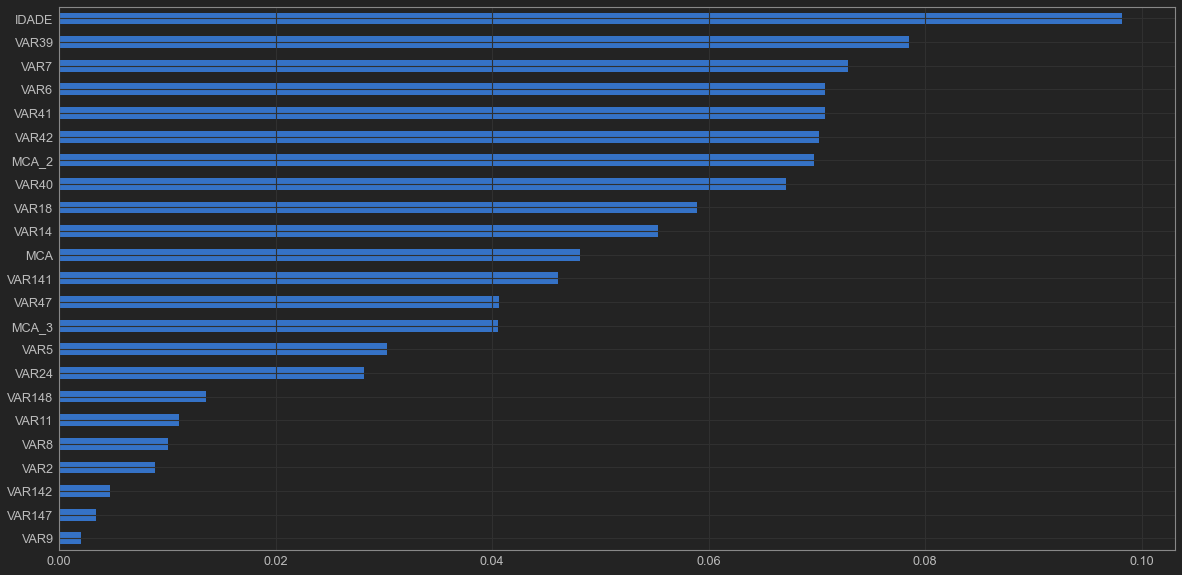

In [97]:
rf_model = RandomForestClassifier(n_jobs= -1)
x_train_rfc = dfx.drop(columns= ['TARGET'])
y_train_rfc = dfx['TARGET']
rf_model.fit(x_train_rfc, y_train_rfc)
plt.figure(figsize= (20, 10))
feat_importances = pd.Series(rf_model.feature_importances_, index= x_train_rfc.columns)
print('Random forest features importance:')
feat_importances.sort_values().plot(kind= 'barh');

Observamos que com essa seleção deste método definimos variáveis com importancia de até 6% aprox.

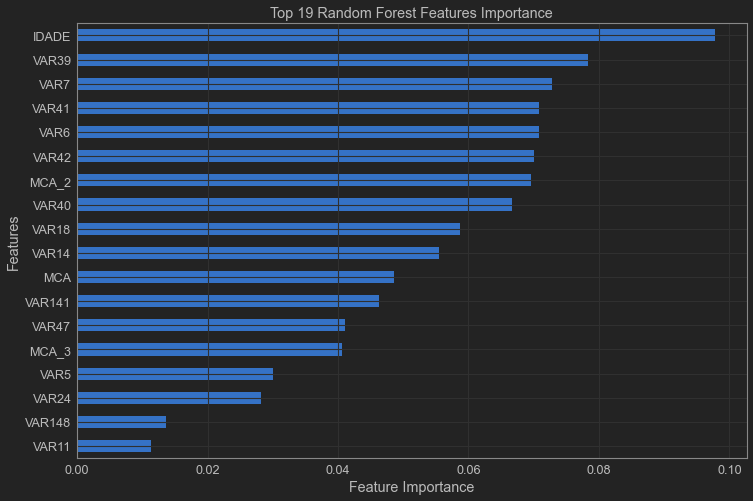

In [98]:
rf_model = RandomForestClassifier(n_jobs=-1)
x_train_rfc = dfx.drop(columns=['TARGET'])
y_train_rfc = dfx['TARGET']
rf_model.fit(x_train_rfc, y_train_rfc)
plt.figure(figsize=(12, 8))
feat_importances = pd.Series(rf_model.feature_importances_, index=x_train_rfc.columns)
feat_importances = feat_importances.sort_values(ascending=True)
top_n = 5
feat_importances[top_n:].plot(kind='barh')
plt.title('Top {} Random Forest Features Importance'.format(len(dfx.columns)- top_n))
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.show() 

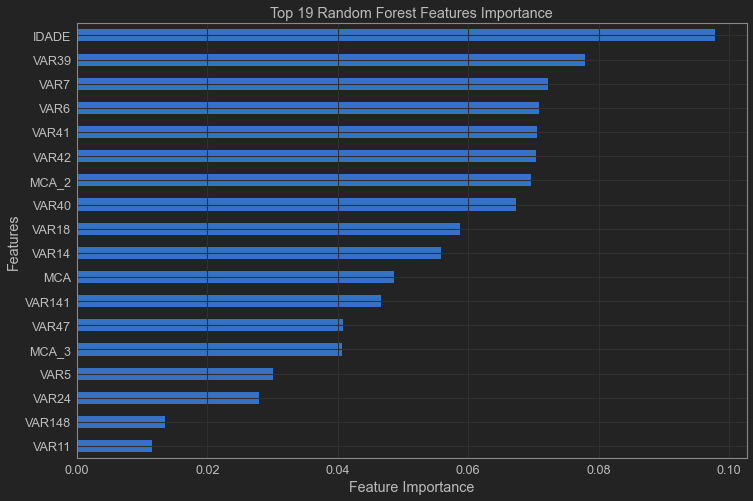

In [99]:
rf_model = RandomForestClassifier(n_jobs=-1)
x_train_rfc = dfx.drop(columns=['TARGET'])
y_train_rfc = dfx['TARGET']
rf_model.fit(x_train_rfc, y_train_rfc)
plt.figure(figsize=(12, 8))
feat_importances = pd.Series(rf_model.feature_importances_, index=x_train_rfc.columns)
feat_importances = feat_importances.sort_values(ascending=True)
top_n = 5
feat_importances[top_n:].plot(kind='barh')
plt.title('Top {} Random Forest Features Importance'.format(len(dfx.columns)- top_n))
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.show() 

In [100]:
feat_importances.tail(25).sort_values(ascending=False)

IDADE     0.097829
VAR39     0.077961
VAR7      0.072267
VAR6      0.070877
VAR41     0.070503
VAR42     0.070450
MCA_2     0.069628
VAR40     0.067277
VAR18     0.058724
VAR14     0.055770
MCA       0.048615
VAR141    0.046596
VAR47     0.040768
MCA_3     0.040607
VAR5      0.030008
VAR24     0.027924
VAR148    0.013566
VAR11     0.011433
VAR8      0.009855
VAR2      0.008842
VAR142    0.004896
VAR147    0.003507
VAR9      0.002099
dtype: float64

### Selection Método Lasso

In [101]:
from sklearn.linear_model import Lasso
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split


x_train_lasso = dfx.drop(columns=['TARGET'])
y_train_lasso = dfx['TARGET']
# Crie uma instância do modelo LASSO
lasso = Lasso(alpha=0.5)  # O parâmetro alpha controla a força da penalização L1 (quanto maior, mais recursos serão selecionados)

# Ajuste o modelo aos dados de treinamento
lasso.fit(x_train_lasso, y_train_lasso)

# Obtenha os coeficientes do modelo
coeficientes = lasso.coef_

# Identifique as features selecionadas (aquelas com coeficientes não nulos)
features_selecionadas = [i for i, coef in enumerate(coeficientes) if coef != 0]

# Exiba as features selecionadas
print("Features selecionadas:", features_selecionadas)


Features selecionadas: [20, 22]


In [107]:
# Obtenha os coeficientes do modelo
coeficientes = lasso.coef_

# Identifique as features selecionadas (aquelas com coeficientes não nulos)
features_selecionadas = x_train_lasso.columns[coeficientes != 0]

# Exiba as features selecionadas
print("Features selecionadas:", features_selecionadas)

Features selecionadas: Index(['MCA', 'MCA_3'], dtype='object')


NOTA: A importancia da melhor variável não chega aos 10%. O que reafirma a complexidade dos dados.

### Método: Recursive Feature Elimination (RFE)
RFE funciona eliminando iterativamente as características menos importantes de um conjunto de dados.

In [108]:
dfx.shape

(127840, 24)

In [109]:
x_train_rfe = dfx.drop(columns= ['TARGET'])
y_train_rfe = dfx['TARGET']
modelorfe = RandomForestClassifier(n_estimators=100, random_state=42)
rfe = RFE(estimator=modelorfe, n_features_to_select=25)
rfe.fit(x_train_rfe, y_train_rfe)
caracteristicas_selecionadas = x_train_rfe.columns[rfe.support_]
print("Características Selecionadas:")
print(caracteristicas_selecionadas) 

Características Selecionadas:
Index(['VAR2', 'IDADE', 'VAR5', 'VAR6', 'VAR7', 'VAR8', 'VAR9', 'VAR11',
       'VAR14', 'VAR18', 'VAR24', 'VAR39', 'VAR40', 'VAR41', 'VAR42', 'VAR47',
       'VAR141', 'VAR142', 'VAR147', 'VAR148', 'MCA', 'MCA_2', 'MCA_3'],
      dtype='object')


As melhores variáveis fornecidas pelo RFE se asemelham do Selector Random Forest.

In [170]:
cols_rfe=['VAR2', 'IDADE', 'VAR5', 'VAR6', 'VAR7', 'VAR9', 'VAR11', 'VAR14',
       'VAR18', 'VAR24', 'VAR39', 'VAR40', 'VAR41', 'VAR42', 'VAR47', 'VAR141',
       'VAR142', 'VAR147', 'VAR148', 'MCA', 'MCA_2', 'MCA_3'] 

### Método: Boruta Selection
Boruta opera por meio de uma abordagem de eliminação gradual de recursos, comparando as características originais com um conjunto de características aleatórias (ruído).

In [110]:
rf_model = RandomForestClassifier(n_jobs = -1)
x_train_boruta = dfx.drop(columns= ['TARGET']).values
y_train_boruta = dfx['TARGET'].values.ravel()
boruta = BorutaPy(rf_model, n_estimators=200, verbose= 2)
boruta.fit(x_train_boruta, y_train_boruta) 

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	23
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	23
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	23
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	23
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	23
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	23
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	23
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	3
Tentative: 	0
Rejected: 	20


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	3
Tentative: 	0
Rejected: 	20


BorutaPy(estimator=RandomForestClassifier(n_estimators=200, n_jobs=-1,
                                          random_state=RandomState(MT19937) at 0x1E74841B258),
         n_estimators=200, random_state=RandomState(MT19937) at 0x1E74841B258,
         verbose=2)

In [111]:
# instantiating the dataset selected columns by the boruta method
cols = boruta.support_.tolist()
boruta_selected_features = dfx.drop(columns= ['TARGET']).iloc[:, cols].columns.to_list()

print('Boruta selected features:')
boruta_selected_features

Boruta selected features:


['IDADE', 'VAR7', 'VAR39']

O resultado do Boruta acabaram sendo desalentadores também, pela pouca quantidade de features identificadas como relevantes para a modelagem do modelo. Mas as três variáveis consideradas acabam dando um direcionamento para um ponto de partida.

In [108]:
cols_boruta = ['IDADE', 'VAR7', 'VAR39']

## Modelos

### Preparação

In [82]:
seed = 6
np.random.seed(seed) 
metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

In [83]:
dfx.shape

(127840, 24)

In [114]:
dfx.columns

Index(['TARGET', 'VAR2', 'IDADE', 'VAR5', 'VAR6', 'VAR7', 'VAR8', 'VAR9',
       'VAR11', 'VAR14', 'VAR18', 'VAR24', 'VAR39', 'VAR40', 'VAR41', 'VAR42',
       'VAR47', 'VAR141', 'VAR142', 'VAR147', 'VAR148', 'MCA', 'MCA_2',
       'MCA_3'],
      dtype='object')

In [84]:
columns = [ 'VAR2', 'IDADE', 'VAR5', 'VAR6', 'VAR7', 'VAR8', 'VAR9',
       'VAR11', 'VAR14', 'VAR18', 'VAR24', 'VAR39', 'VAR40', 'VAR41', 'VAR42',
       'VAR47', 'VAR141', 'VAR142', 'VAR147', 'VAR148', 'MCA', 'MCA_2',
       'MCA_3']

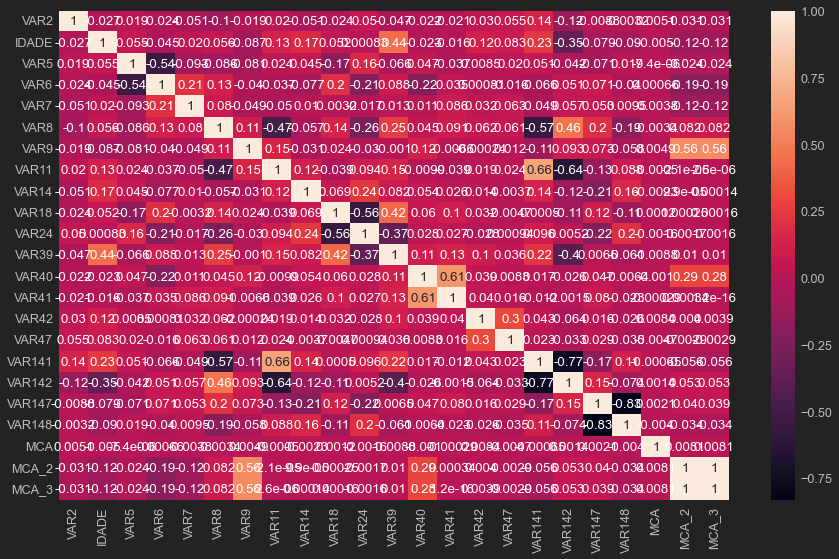

In [85]:
df_corr = dfx[columns].copy()  
fig = plt.figure(figsize =(15, 9)) 
correlation = df_corr.corr(method='pearson') 
sns.heatmap(correlation,annot=True); 

In [86]:
df_corr = dfx[columns].copy()
correlacoes = df_corr.corr()
tabela_correlacoes = pd.DataFrame(correlacoes)
print(tabela_correlacoes)

            VAR2     IDADE      VAR5      VAR6      VAR7      VAR8      VAR9  \
VAR2    1.000000 -0.026553  0.019483 -0.024118 -0.051129 -0.101671 -0.019176   
IDADE  -0.026553  1.000000  0.054834 -0.045063  0.019577  0.055727 -0.087048   
VAR5    0.019483  0.054834  1.000000 -0.536348 -0.093130 -0.086124 -0.080758   
VAR6   -0.024118 -0.045063 -0.536348  1.000000  0.209080  0.126684 -0.040287   
VAR7   -0.051129  0.019577 -0.093130  0.209080  1.000000  0.080436 -0.048507   
VAR8   -0.101671  0.055727 -0.086124  0.126684  0.080436  1.000000  0.109788   
VAR9   -0.019176 -0.087048 -0.080758 -0.040287 -0.048507  0.109788  1.000000   
VAR11   0.020436  0.131710  0.024215 -0.036502 -0.049531 -0.474536  0.148041   
VAR14  -0.051341  0.174463  0.044662 -0.077409  0.009991 -0.056780 -0.031457   
VAR18  -0.023888  0.052456 -0.168326  0.204452 -0.003153  0.136494  0.024010   
VAR24   0.049595  0.000831  0.155930 -0.213210 -0.016717 -0.263532 -0.030248   
VAR39  -0.047059  0.435502 -0.066445  0.

In [87]:
len(columns)

23

### Train Test Split

In [88]:
X_train = dfx[columns]
#X_train = dfx.drop(columns=['TARGET'])
y_train = df_reserva['TARGET']
X_test = dfx_tes[columns]
#X_test = dfx_tes.drop(columns=['TARGET'])
y_test = dfx_tes['TARGET']

In [89]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(127840, 23)
(127840,)
(63099, 23)
(63099,)


In [84]:
# Guardando CSV prontos e tratados para eventual uso posterior
X_train.to_csv('data_base/X_train_tratado2.csv', index=False)
X_test.to_csv('data_base/X_test_tratado2.csv', index=False)
y_train.to_csv('data_base/y_train_tratado2.csv', index=False)
y_test.to_csv('data_base/y_test_tratado2.csv', index=False)

### Balanceamento dos Dados

In [90]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train == 0)))

Before OverSampling, counts of label '1': 102761
Before OverSampling, counts of label '0': 25079 



In [91]:
cv = KFold(n_splits=3, shuffle=True, random_state=seed)

Best parameters : {'smote__sampling_strategy': 0.2469387755102041}


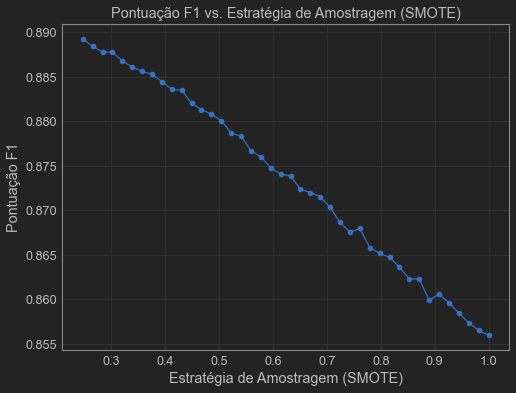

In [93]:
# executado as 17:31 
pipe = make_pipeline(
    SMOTE(),
    RandomForestClassifier(n_estimators=50)
)
# Defina uma lista de valores de peso para a estratégia de amostragem do SMOTE
weights = np.linspace(0.1, 1.0)
# Crie um objeto GridSearchCV para ajustar o modelo
gsc = GridSearchCV(
    estimator=pipe,
    param_grid={
        'smote__sampling_strategy': weights
    },
    scoring='f1',
    cv=3
)
# Ajuste o modelo aos dados
grid_result = gsc.fit(X_train, y_train)
# Imprima os melhores parâmetros encontrados
print("Best parameters : %s" % grid_result.best_params_)
# Crie um DataFrame para as pontuações F1
weight_f1_score_df = pd.DataFrame(
    {
        'score': grid_result.cv_results_['mean_test_score'],
        'weight': weights
    }
)
# Plote um gráfico de linha para visualizar as pontuações F1
plt.figure(figsize=(8, 6))
plt.plot(weight_f1_score_df['weight'], weight_f1_score_df['score'], marker='o', linestyle='-')
plt.title('Pontuação F1 vs. Estratégia de Amostragem (SMOTE)')
plt.xlabel('Estratégia de Amostragem (SMOTE)')
plt.ylabel('Pontuação F1')
plt.grid(True)
plt.show() 

Isso significa que a estratégia de amostragem do SMOTE foi ajustada para equilibrar as classes alvo gerando uma proporção de aproximadamente 24.69% de exemplos sintéticos em relação aos exemplos originais da classe minoritária.

In [94]:
#ros = SMOTE(random_state=seed, sampling_strategy= 0.63666666666666667) 
ros = SMOTE(random_state=seed, sampling_strategy= 0.2469387755102041) 
X_train_over, y_train_over = ros.fit_resample(X_train, y_train) 

In [70]:
# Aplicar SMOTE-KNN no conjunto de treinamento
### smote = SMOTE(sampling_strategy='auto', random_state=42, k_neighbors=5)
### X_train_over, y_train_over = smote.fit_resample(X_train, y_train)

In [95]:
print("After OverSampling, counts of label '1': {}".format(sum(y_train_over == 1)))
print("After OverSampling, counts of label '0': {} \n".format(sum(y_train_over == 0)))

After OverSampling, counts of label '1': 102761
After OverSampling, counts of label '0': 25375 



### Aplicação de Algoritmos

#### Algoritmo: Linear Discriminant Analysis

In [96]:
X_train_lda = X_train_over
#X_train_lda = X_train
X_test_lda = X_test
y_train_lda = y_train_over
#y_train_lda = y_train
y_test_lda = y_test

In [97]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(n_components=1)  # Especifique o número desejado de componentes
X_lda_train = lda.fit_transform(X_train_lda, y_train_lda)

In [98]:
df_lda_train = pd.DataFrame(data=X_lda_train, columns=['Componente_1'])
df_lda_train['TARGET'] = y_train_lda
print(df_lda_train.head())

   Componente_1  TARGET
0     -0.751766       1
1     -0.401182       1
2      0.527478       1
3      0.189607       1
4      1.624200       1


In [99]:
from sklearn.linear_model import LogisticRegression

model_lda = LogisticRegression()
model_lda.fit(X_lda_train, y_train_lda)

X_lda_test = lda.transform(X_test_lda)
y_pred_lda = model_lda.predict(X_lda_test)

In [100]:
from sklearn.metrics import roc_auc_score, roc_curve
#precision_lda0 = precision_score(y_test_lda, y_pred_lda, labels=[0], average='micro')
#recall_lda0 = recall_score(y_test_lda, y_pred_lda, labels=[0], average='micro')
#score_lda0 = accuracy_score(y_test_lda, y_pred_lda)
#roc_auc_lda0 = roc_auc_score(y_test_lda, y_pred_lda)

score_lda = accuracy_score(y_test_lda, y_pred_lda)
recall_lda = recall_score(y_test_lda, y_pred_lda)
precision_lda = precision_score(y_test_lda, y_pred_lda)


In [101]:
#from sklearn.metrics import roc_auc_score, roc_curve

roc_auc_lda = roc_auc_score(y_test_lda, y_pred_lda)
#print("ROC-AUC Score:", roc_auc_lda)

#### Algoritmo: XGBoost 

In [93]:
# Crie uma instância do modelo XGBoost
XGBoost_model = xgb.XGBClassifier(
    max_depth=5,
    learning_rate=0.1,
    n_estimators=100,
    objective='binary:logistic',  # Use 'binary:logistic' para classificação binária
    eval_metric='error',
    random_state=42,
    scale_pos_weight=1
)
XGBoost_model.fit(X_train_over, y_train_over)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='error', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=5, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [94]:
xgb_predic = XGBoost_model.predict(X_test)

score_xg = accuracy_score(y_test ,xgb_predic)
precision_xg = precision_score(y_test,xgb_predic)
recall_xg = recall_score(y_test,xgb_predic) 
print(score_xg)
print(precision_xg)
print(recall_xg)

0.7108647076183651
0.8119647684660329
0.8262019273430706


In [325]:
from sklearn.model_selection import cross_validate
import xgboost as xgb
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score

# Defina os hiperparâmetros do modelo
XGBoost_model = xgb.XGBClassifier(
    max_depth=5,
    learning_rate=0.1,
    n_estimators=100,
    objective='binary:logistic',
    eval_metric='error',
    random_state=42,
    scale_pos_weight=1,  # Não use class_weight quando estiver balanceando manualmente
)

# Defina as métricas que você deseja calcular
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score)
}

results_xgb = cross_validate(XGBoost_model, X_train_over, y_train_over, cv=5, scoring=scoring)

# Extrair os resultados das métricas
mean_accuracy_xgb = results_xgb['test_accuracy'].mean()
mean_precision_xgb = results_xgb['test_precision'].mean()
mean_recall_xgb = results_xgb['test_recall'].mean()

print("Média da Acurácia na Valid. Cruzada:", mean_accuracy_xgb)
print("Média da Precisão na Valid. Cruzada:", mean_precision_xgb)
print("Média do Recall na Valid. Cruzada:", mean_recall_xgb)

Média da Acurácia na Valid. Cruzada: 0.7597765687211775
Média da Precisão na Valid. Cruzada: 0.7560116816627025
Média do Recall na Valid. Cruzada: 0.9945454545454545


In [188]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score
import xgboost as xgb
import numpy as np

# Defina os hiperparâmetros do modelo
params = {
    'max_depth': 5,
    'learning_rate': 0.1,
    'n_estimators': 100,
    'objective': 'binary:logistic',
    'eval_metric': 'error',
    'random_state': 42,
    'scale_pos_weight': 1,  # Não use class_weight quando estiver balanceando manualmente

}

# Crie uma instância do modelo XGBoost
model_xgb = xgb.XGBClassifier(**params)

# Inicialize um objeto StratifiedKFold para realizar a validação cruzada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Listas para armazenar as métricas
roc_auc_scores = []
accuracy_scores = []
precision_scores = []
recall_scores = []

# Realize a validação cruzada
for train_idx, val_idx in cv.split(X_train_over, y_train_over):
    X_train_fold, X_val_fold = X_train_over.iloc[train_idx], X_train_over.iloc[val_idx]
    y_train_fold, y_val_fold = y_train_over.iloc[train_idx], y_train_over.iloc[val_idx]
    
    model_xgb.fit(X_train_fold, y_train_fold)
    y_probas = model_xgb.predict_proba(X_val_fold)
    y_pred_xgb = np.argmax(y_probas, axis=1)
    
    roc_auc = roc_auc_score(y_val_fold, y_probas[:, 1])
    accuracy = accuracy_score(y_val_fold, y_pred_xgb)
    precision = precision_score(y_val_fold, y_pred_xgb)
    recall = recall_score(y_val_fold, y_pred_xgb)
    
    roc_auc_scores.append(roc_auc)
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)

# Calcule as médias das métricas na validação cruzada
mean_roc_auc_xgb = np.mean(roc_auc_scores)
mean_accuracy_xgb = np.mean(accuracy_scores)
mean_precision_xgb = np.mean(precision_scores)
mean_recall_xgb = np.mean(recall_scores)

print("Média da AUC-ROC na Valid. Cruzada (XGBoost):", mean_roc_auc_xgb)
print("Média da Acurácia na Valid. Cruzada (XGBoost):", mean_accuracy_xgb)
print("Média da Precisão na Valid. Cruzada (XGBoost):", mean_precision_xgb)
print("Média do Recall na Valid. Cruzada (XGBoost):", mean_recall_xgb)


Média da AUC-ROC na Valid. Cruzada (XGBoost): 0.7465579869547387
Média da Acurácia na Valid. Cruzada (XGBoost): 0.7930679446289044
Média da Precisão na Valid. Cruzada (XGBoost): 0.7802032603631541
Média do Recall na Valid. Cruzada (XGBoost): 0.9984877622377623


In [298]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score
import xgboost as xgb
import numpy as np

# Defina os hiperparâmetros do modelo
params = {
    'max_depth': 5,
    'learning_rate': 0.1,
    'n_estimators': 100,
    'objective': 'binary:logistic',
    'eval_metric': 'error',
    'random_state': 42,
    'scale_pos_weight': 1,  # Não use class_weight quando estiver balanceando manualmente

}

# Crie uma instância do modelo XGBoost
model_xgb = xgb.XGBClassifier(**params)

# Inicialize um objeto StratifiedKFold para realizar a validação cruzada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Listas para armazenar as métricas
roc_auc_scores = []
accuracy_scores = []
precision_scores = []
recall_scores = []

# Realize a validação cruzada
for train_idx, val_idx in cv.split(X_train_over, y_train_over):
    X_train_fold, X_val_fold = X_train_over.iloc[train_idx], X_train_over.iloc[val_idx]
    y_train_fold, y_val_fold = y_train_over.iloc[train_idx], y_train_over.iloc[val_idx]
    
    model_xgb.fit(X_train_fold, y_train_fold)
    y_probas = model_xgb.predict_proba(X_val_fold)
    y_pred_xgb = np.argmax(y_probas, axis=1)
    
    roc_auc = roc_auc_score(y_val_fold, y_probas[:, 1])
    accuracy = accuracy_score(y_val_fold, y_pred_xgb)
    precision = precision_score(y_val_fold, y_pred_xgb)
    recall = recall_score(y_val_fold, y_pred_xgb)
    
    roc_auc_scores.append(roc_auc)
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)

# Calcule as médias das métricas na validação cruzada
mean_roc_auc_xgb = np.mean(roc_auc_scores)
mean_accuracy_xgb = np.mean(accuracy_scores)
mean_precision_xgb = np.mean(precision_scores)
mean_recall_xgb = np.mean(recall_scores)

print("Média da AUC-ROC na Valid. Cruzada (XGBoost):", mean_roc_auc_xgb)
print("Média da Acurácia na Valid. Cruzada (XGBoost):", mean_accuracy_xgb)
print("Média da Precisão na Valid. Cruzada (XGBoost):", mean_precision_xgb)
print("Média do Recall na Valid. Cruzada (XGBoost):", mean_recall_xgb)


Média da AUC-ROC na Valid. Cruzada (XGBoost): 0.7290518169951563
Média da Acurácia na Valid. Cruzada (XGBoost): 0.7728883497228314
Média da Precisão na Valid. Cruzada (XGBoost): 0.7661684367129323
Média do Recall na Valid. Cruzada (XGBoost): 0.9925349650349651


In [103]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score
import xgboost as xgb
import numpy as np

# Defina os hiperparâmetros do modelo
params = {
    'max_depth': 5,
    'learning_rate': 0.1,
    'n_estimators': 100,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'random_state': 42,
    'scale_pos_weight': 1,  # Não use class_weight quando estiver balanceando manualmente
}

# Crie uma instância do modelo XGBoost
model_xgb = xgb.XGBClassifier(**params)

# Inicialize um objeto StratifiedKFold para realizar a validação cruzada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Listas para armazenar as métricas
roc_auc_scores = []
accuracy_scores = []
precision_scores = []
recall_scores = []

# Realize a validação cruzada
for train_idx, val_idx in cv.split(X_train_over, y_train_over):
    X_train_fold, X_val_fold = X_train_over.iloc[train_idx], X_train_over.iloc[val_idx]
    y_train_fold, y_val_fold = y_train_over.iloc[train_idx], y_train_over.iloc[val_idx]
    
    model_xgb.fit(X_train_fold, y_train_fold)
    y_probas = model_xgb.predict_proba(X_val_fold)
    y_pred_xgb = np.argmax(y_probas, axis=1)
    
    roc_auc = roc_auc_score(y_val_fold, y_probas[:, 1])
    accuracy = accuracy_score(y_val_fold, y_pred_xgb)
    precision = precision_score(y_val_fold, y_pred_xgb)
    recall = recall_score(y_val_fold, y_pred_xgb)
    
    roc_auc_scores.append(roc_auc)
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)

# Calcule as médias das métricas na validação cruzada
mean_roc_auc_xgb = np.mean(roc_auc_scores)
mean_accuracy_xgb = np.mean(accuracy_scores)
mean_precision_xgb = np.mean(precision_scores)
mean_recall_xgb = np.mean(recall_scores)

print("Média da AUC-ROC na Valid. Cruzada (XGBoost):", mean_roc_auc_xgb)
print("Média da Acurácia na Valid. Cruzada (XGBoost):", mean_accuracy_xgb)
print("Média da Precisão na Valid. Cruzada (XGBoost):", mean_precision_xgb)
print("Média do Recall na Valid. Cruzada (XGBoost):", mean_recall_xgb)
### esse é o ultimo... com validação cruzada e treinando o modelo dentro dela

Média da AUC-ROC na Valid. Cruzada (XGBoost): 0.658571029901587
Média da Acurácia na Valid. Cruzada (XGBoost): 0.8023194114916148
Média da Precisão na Valid. Cruzada (XGBoost): 0.802888425568594
Média do Recall na Valid. Cruzada (XGBoost): 0.9986862753431268


#### Algoritmo:Decision Tree 

In [ ]:
modelo_arvore = DecisionTreeClassifier()
param_dist = {
    'criterion': ['gini', 'entropy'],
    'max_depth': range(1, 40),
    'min_impurity_decrease': np.arange(0.0, 0.3)
}
n_iter_search = 100 
random_search = RandomizedSearchCV(estimator=modelo_arvore,
                                   param_distributions=param_dist,
                                   n_iter=n_iter_search,
                                   cv=cv,
                                   scoring='f1')
random_search.fit(X_train_over, y_train_over)

In [ ]:
random_search.best_params_

In [282]:
model_tree = DecisionTreeClassifier(max_depth=20, criterion='gini')
model_tree.fit(X_train_over, y_train_over)

DecisionTreeClassifier(max_depth=20)

In [283]:
tree_predic = model_tree.predict(X_test)

score = accuracy_score(y_test ,tree_predic)
precision = precision_score(y_test,tree_predic)
recall = recall_score(y_test,tree_predic)
print(score)
print(precision)
print(recall)

0.6547071967620894
0.8140330072141516
0.7309350985855503


In [284]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Defina os hiperparâmetros do modelo
model_tree = DecisionTreeClassifier(max_depth=20, criterion='gini')

# Defina as métricas que você deseja calcular
scoring = {'accuracy': 'accuracy', 'precision': 'precision', 'recall': 'recall'}

# Aplicar validação cruzada com as métricas especificadas
results_dt = cross_validate(model_tree, X_train_over, y_train_over, cv=5, scoring=scoring)            

# Extrair os resultados das métricas
mean_accuracy_dt = results_dt['test_accuracy'].mean()
mean_precision_dt = results_dt['test_precision'].mean()
mean_recall_dt = results_dt['test_recall'].mean()

print("Média da Acurácia na Valid. Cruzada:", mean_accuracy_dt)
print("Média da Precisão na Valid. Cruzada:", mean_precision_dt)
print("Média do Recall na Valid. Cruzada:", mean_recall_dt)

NameError: name 'cross_validate' is not defined

#### Algoritmo: Logistic Regression

In [102]:
model_rl = LogisticRegression(
    C=0.1,            
    penalty='l1',     
    solver='liblinear',  
    class_weight='balanced',  
    max_iter=20      
)
model_rl.fit(X_train_over, y_train_over)

LogisticRegression(C=0.1, class_weight='balanced', max_iter=20, penalty='l1',
                   solver='liblinear')

In [103]:
pred = model_rl.predict(X_test)

score1 = accuracy_score(y_test ,pred)
precision1 = precision_score(y_test, pred)
recall1 = recall_score(y_test, pred)

print(score1)
print(precision1)
print(recall1)

0.5824163469511081
0.8533821617174854
0.5707136138569933


In [105]:
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score
model_rl = LogisticRegression(
    C=0.1,            
    penalty='l1',     
    solver='liblinear',  
    class_weight='balanced',  
    max_iter=20      
) 
scoring = {'accuracy': 'accuracy', 'precision': 'precision', 'recall': 'recall'}

results_lr = cross_validate(model_rl, X_train_over, y_train_over, cv=5, scoring=scoring)

mean_accuracy_lr = results_lr['test_accuracy'].mean()
mean_precision_lr = results_lr['test_precision'].mean()
mean_recall_lr = results_lr['test_recall'].mean()
print("Média da Acurácia na Valid. Cruzada:", mean_accuracy_lr)
print("Média da Precisão na Valid. Cruzada:", mean_precision_lr)
print("Média do Recall na Valid. Cruzada:", mean_recall_lr)

Média da Acurácia na Valid. Cruzada: 0.58710169345276
Média da Precisão na Valid. Cruzada: 0.8102227437124169
Média do Recall na Valid. Cruzada: 0.5690821678321678


#### Algoritmo: Random Forest 

In [106]:
clf = RandomForestClassifier(n_estimators=150, max_depth=3,
                             class_weight='balanced', random_state=0)

clf.fit(X_train_over, y_train_over)
y_pred_rf = clf.predict(X_test)

score_rf = accuracy_score(y_test ,y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)

In [107]:
print(score_rf)
print(precision_rf)
print(recall_rf)

0.5817698891184283
0.8467356999400089
0.5761265018545797


In [126]:
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score

# Criar uma instância do modelo Random Forest
clf = RandomForestClassifier(n_estimators=150, max_depth=3,
                             class_weight='balanced', random_state=0)

# Definir as métricas que você deseja calcular, incluindo 'roc_auc'
scoring = {'accuracy': 'accuracy', 'recall': 'recall', 'precision': 'precision', 'roc_auc': 'roc_auc'}

# Aplicar validação cruzada com as métricas especificadas
results_rf = cross_validate(clf, X_train_over, y_train_over, cv=5, scoring=scoring)

# Extrair os resultados das métricas
mean_accuracy_rf = results_rf['test_accuracy'].mean()
mean_recall_rf = results_rf['test_recall'].mean()
mean_precision_rf = results_rf['test_precision'].mean()
mean_roc_auc_rf = results_rf['test_roc_auc'].mean()

print("Média da Acurácia na Valid. Cruzada:", mean_accuracy_rf)
print("Média do Recall na Valid. Cruzada:", mean_recall_rf)
print("Média da Precisão na Valid. Cruzada:", mean_precision_rf)
print("Média da AUC-ROC na Valid. Cruzada:", mean_roc_auc_rf)

Média da Acurácia na Valid. Cruzada: 0.6012561921417976
Média do Recall na Valid. Cruzada: 0.5995017482517483
Média da Precisão na Valid. Cruzada: 0.8061650156669804
Média da AUC-ROC na Valid. Cruzada: 0.6404723989691623


In [104]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# Defina os hiperparâmetros do modelo
params = {
    'n_estimators': 100,
    'max_depth': 5,
    'random_state': 42,
    'class_weight': 'balanced'
}

# Crie uma instância do modelo Random Forest
model_rf = RandomForestClassifier(**params)

# Inicialize um objeto StratifiedKFold para realizar a validação cruzada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Listas para armazenar as métricas
roc_auc_scores = []
accuracy_scores = []
precision_scores = []
recall_scores = []

# Realize a validação cruzada
for train_idx, val_idx in cv.split(X_train_over, y_train_over):
    X_train_fold, X_val_fold = X_train_over.iloc[train_idx], X_train_over.iloc[val_idx]
    y_train_fold, y_val_fold = y_train_over.iloc[train_idx], y_train_over.iloc[val_idx]
    
    model_rf.fit(X_train_fold, y_train_fold)
    y_probas = model_rf.predict_proba(X_val_fold)
    y_pred_rf = np.argmax(y_probas, axis=1)
    
    roc_auc = roc_auc_score(y_val_fold, y_probas[:, 1])
    accuracy = accuracy_score(y_val_fold, y_pred_rf)
    precision = precision_score(y_val_fold, y_pred_rf)
    recall = recall_score(y_val_fold, y_pred_rf)
    
    roc_auc_scores.append(roc_auc)
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)

# Calcule as médias das métricas na validação cruzada
mean_roc_auc_rf = np.mean(roc_auc_scores)
mean_accuracy_rf = np.mean(accuracy_scores)
mean_precision_rf = np.mean(precision_scores)
mean_recall_rf = np.mean(recall_scores)

print("Média da AUC-ROC na Valid. Cruzada (Random Forest):", mean_roc_auc_rf)
print("Média da Acurácia na Valid. Cruzada (Random Forest):", mean_accuracy_rf)
print("Média da Precisão na Valid. Cruzada (Random Forest):", mean_precision_rf)
print("Média do Recall na Valid. Cruzada (Random Forest):", mean_recall_rf)


Média da AUC-ROC na Valid. Cruzada (Random Forest): 0.6412968239887753
Média da Acurácia na Valid. Cruzada (Random Forest): 0.5819831767393028
Média da Precisão na Valid. Cruzada (Random Forest): 0.8632990341532555
Média do Recall na Valid. Cruzada (Random Forest): 0.5688344252042168


In [ ]:
'''
Média da AUC-ROC na Valid. Cruzada (Random Forest): 0.6610025091218106
Média da Acurácia na Valid. Cruzada (Random Forest): 0.5898604386214753
Média da Precisão na Valid. Cruzada (Random Forest): 0.8234550419150463
Média do Recall na Valid. Cruzada (Random Forest): 0.5594242913492534
'''

#### Algoritmo: LightGBM 

In [116]:
import lightgbm as lgb
params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'metric': 'binary_logloss',
    'n_estimators': 200,
    'learning_rate': 0.05,
    'max_depth': 20,
    'num_leaves': 50,
    'random_state': 42,
    'class_weight': 'balanced'
}

model_lgb = lgb.LGBMClassifier(**params)
model_lgb.fit(X_train_over, y_train_over)



[LightGBM] [Info] Number of positive: 114400, number of negative: 41946
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017551 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 22776
[LightGBM] [Info] Number of data points in the train set: 156346, number of used features: 111
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


LGBMClassifier(class_weight='balanced', learning_rate=0.05, max_depth=20,
               metric='binary_logloss', n_estimators=200, num_leaves=50,
               objective='binary', random_state=42)

In [117]:
y_pred_lgb = model_lgb.predict(X_test)

score_lgb = accuracy_score(y_test ,y_pred_lgb)
precision_lgb = precision_score(y_test, y_pred_lgb)
recall_lgb = recall_score(y_test, y_pred_lgb)

print(score_lgb)
print(precision_lgb)
print(recall_lgb)

0.5457790519555349
0.8562996796773046
0.5123786536993984


In [106]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score
import lightgbm as lgb
import numpy as np

# Defina os hiperparâmetros do modelo
params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'metric': 'binary_logloss',
    'n_estimators': 200,
    'learning_rate': 0.05,
    'max_depth': 20,
    'num_leaves': 50,
    'random_state': 42,
    'class_weight': 'balanced'
}

# Crie uma instância do modelo LightGBM
model_lgb = lgb.LGBMClassifier(**params)

# Inicialize um objeto StratifiedKFold para realizar a validação cruzada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Listas para armazenar as métricas
roc_auc_scores = []
accuracy_scores = []
precision_scores = []
recall_scores = []

# Realize a validação cruzada
for train_idx, val_idx in cv.split(X_train_over, y_train_over):
    X_train_fold, X_val_fold = X_train_over.iloc[train_idx], X_train_over.iloc[val_idx]
    y_train_fold, y_val_fold = y_train_over.iloc[train_idx], y_train_over.iloc[val_idx]
    
    model_lgb.fit(X_train_fold, y_train_fold)
    y_probas = model_lgb.predict_proba(X_val_fold)
    y_pred_lgb = np.argmax(y_probas, axis=1)
    
    roc_auc = roc_auc_score(y_val_fold, y_probas[:, 1])
    accuracy = accuracy_score(y_val_fold, y_pred_lgb)
    precision = precision_score(y_val_fold, y_pred_lgb)
    recall = recall_score(y_val_fold, y_pred_lgb)
    
    roc_auc_scores.append(roc_auc)
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)

# Calcule as médias das métricas na validação cruzada
mean_roc_auc_lgb = np.mean(roc_auc_scores)
mean_accuracy_lgb = np.mean(accuracy_scores)
mean_precision_lgb = np.mean(precision_scores)
mean_recall_lgb = np.mean(recall_scores)

print("Média da AUC-ROC na Valid. Cruzada:", mean_roc_auc_lgb)
print("Média da Acurácia na Valid. Cruzada:", mean_accuracy_lgb)
print("Média da Precisão na Valid. Cruzada:", mean_precision_lgb)
print("Média do Recall na Valid. Cruzada:", mean_recall_lgb)


[LightGBM] [Info] Number of positive: 82208, number of negative: 20300
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009840 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3580
[LightGBM] [Info] Number of data points in the train set: 102508, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Number of positive: 82209, number of negative: 20300
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007174 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3576
[LightGBM] [Info] Number of data points in the train set: 102509, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[L

In [ ]:
'''
Média da AUC-ROC na Valid. Cruzada: 0.765528590603863
Média da Acurácia na Valid. Cruzada: 0.7265807462261463
Média da Precisão na Valid. Cruzada: 0.8439926388871408
Média do Recall na Valid. Cruzada: 0.7683654433504492
'''

[LightGBM] [Info] Number of positive: 91520, number of negative: 33556
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011422 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 22602
[LightGBM] [Info] Number of data points in the train set: 125076, number of used features: 111
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Number of positive: 91520, number of negative: 33557
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010797 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 22606
[LightGBM] [Info] Number of data points in the train set: 125077, number of used features: 111
[LightGBM] [In

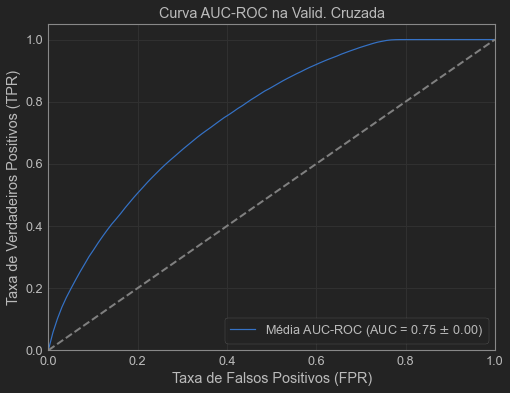

In [186]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Defina novamente seus dados, modelo e validação cruzada, se necessário
# Certifique-se de que as variáveis X_train_over e y_train_over estão definidas

# Inicialize um objeto StratifiedKFold para realizar a validação cruzada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Listas para armazenar as métricas
roc_auc_scores = []

# Listas para armazenar os valores de FPR (taxa de falsos positivos) e TPR (taxa de verdadeiros positivos)
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

# Crie uma figura para o gráfico AUC-ROC
plt.figure(figsize=(8, 6))

# Realize a validação cruzada
for train_idx, val_idx in cv.split(X_train_over, y_train_over):
    X_train_fold, X_val_fold = X_train_over.iloc[train_idx], X_train_over.iloc[val_idx]
    y_train_fold, y_val_fold = y_train_over.iloc[train_idx], y_train_over.iloc[val_idx]
    
    model_lgb.fit(X_train_fold, y_train_fold)
    y_probas_lgb = model_lgb.predict_proba(X_val_fold)[:, 1]
    
    roc_auc = roc_auc_score(y_val_fold, y_probas_lgb)
    roc_auc_scores.append(roc_auc)
    
    fpr, tpr, _ = roc_curve(y_val_fold, y_probas_lgb)
    all_tpr.append(np.interp(mean_fpr, fpr, tpr))
    
# Calcule a média e o desvio padrão das métricas da AUC-ROC
mean_roc_auc_lgb = np.mean(roc_auc_scores)
std_roc_auc_lgb = np.std(roc_auc_scores)

# Plote a curva média da AUC-ROC
mean_tpr = np.mean(all_tpr, axis=0)
plt.plot(mean_fpr, mean_tpr, color='b', label=f'Média AUC-ROC (AUC = {mean_roc_auc_lgb:.2f} $\pm$ {std_roc_auc_lgb:.2f})')

# Configurações do gráfico
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curva AUC-ROC na Valid. Cruzada')
plt.legend(loc='lower right')

plt.show()


#### Performance dos Modelos

Nota: Podemos observar que o modelo se aproxima da aleatoriedade, mas do que da perfeição (igual a 1). AInda temos muito trabalhar no modelo.

In [ ]:
# CURVA AUC-ROC COM VALIDAÇÃO CRUZADA

#### Algoritmo: MLP

In [136]:
X_train_over

,VAR2,IDADE,VAR5,VAR6,VAR7,VAR8,VAR9,VAR11,VAR14,VAR18,VAR24,VAR39,VAR40,VAR41,VAR42,VAR47,VAR141,VAR142,VAR147,VAR148,MCA,MCA_2,MCA_3
0,0,-0.667246,0.962963,-0.532226,-0.022855,4,4,0.000000,0.950739,-0.003682,0.017000,0.378548,0.451697,0.438720,0.499008,1.000000,-0.841441,4,1.0,2,1.580168,-0.150253,0.153846
1,0,-0.207721,0.148148,0.119004,0.729488,4,4,0.000000,0.448276,0.134993,0.017000,0.476678,0.401271,0.393429,0.508360,0.000000,-0.500343,4,1.0,2,-0.218200,-0.586918,0.384615
2,1,1.030302,0.629630,0.600766,0.349974,4,4,0.000000,0.625616,0.541343,0.017000,0.532506,0.484427,0.546715,0.480883,1.000000,0.113844,4,1.0,2,0.112924,-0.570533,0.461538
3,0,0.331841,0.518519,0.872888,-0.057127,5,4,1.000000,0.330049,-0.593858,0.138000,0.273552,0.533198,0.786395,0.462936,0.000000,-0.177287,4,1.0,2,-0.218200,0.430871,-0.769231
4,0,0.838058,0.851852,-0.833166,-0.543330,5,4,1.000000,0.536946,0.680019,0.000000,0.682983,0.770025,0.959874,0.477417,0.503000,1.298325,3,1.0,2,1.305633,0.394094,-0.615385
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140435,0,0.234771,0.570584,-0.383633,0.162753,5,4,1.000000,0.460855,-0.807716,0.160375,0.500252,0.504771,0.523423,0.470119,0.684160,-0.102114,4,1.0,3,-0.136211,-0.726372,0.256759
140436,1,0.052822,0.407407,-0.271459,-0.952661,4,4,0.000000,0.625012,0.470349,0.139040,0.471365,0.499770,0.846059,0.534336,1.000000,0.301561,4,1.0,2,1.323411,0.609124,-0.674515
140437,1,-0.299643,0.592593,0.405812,0.972966,4,4,0.000000,0.310734,0.134739,0.020302,0.298428,0.492716,0.439826,0.508360,0.000806,0.116272,4,1.0,3,-0.218200,-0.487683,0.168787
140438,0,0.220562,0.524172,0.432039,0.944105,4,4,0.000000,0.364834,-0.012814,0.051466,0.219752,0.732439,0.909221,0.511597,1.000000,-0.188709,4,1.0,2,1.030119,0.452700,-0.577217


In [138]:
!pip install tensorflow 

  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Using cached gast-0.4.0-py3-none-any.whl (9.8 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cached pyasn1_modules-0.3.0-py2.py3-none-any.whl (181 kB)
  Using cached rsa-4.9-py3-none-any.whl (34 kB)
  Using cached requests_oauthlib-1.3.1-py2.py3-none-any.whl (23 kB)
  Using cached pyasn1-0.5.0-py2.py3-none-any.whl (83 kB)
  Using cached oauthlib-3.2.2-py3-none-any.whl (151 kB)
  Created wheel for clang: filename=clang-5.0-py3-none-any.whl size=30694 sha256=49811addf1d76408aab8216776cbe24f112aee85f6c73e0deee76c2a9abf936f
  Stored in directory: c:\users\dpand\appdata\local\pip\cache\wheels\22\4c\94\0583f60c9c5b6024ed64f290cb2d43b06bb4f75577dc3c93a7
  Created wheel for termcolor: filename=termcolor-1.1.0-py3-none-any.whl size=4848 sha256=faeef5ce1369e142a3bbec3a8d41d8e1b8b9e27f6317d9fb28011858c2de7e15
  Stored in directory: c:\users\dpand\appdata\

In [107]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Inicialize o MLPClassifier com hiperparâmetros iniciais
mlp = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42)

# Treine o modelo no conjunto de treinamento oversampled
mlp.fit(X_train_over, y_train_over)

# Faça previsões no conjunto de teste
y_pred_mlp = mlp.predict(X_test)

# Calcule as métricas de desempenho
accuracy = accuracy_score(y_test, y_pred_mlp)
precision = precision_score(y_test, y_pred_mlp)
recall = recall_score(y_test, y_pred_mlp)

print("Acurácia:", accuracy)
print("Precisão:", precision)
print("Recall:", recall)

Acurácia: 0.7939586998209164
Precisão: 0.8043913141677153
Recall: 0.9827344935648541


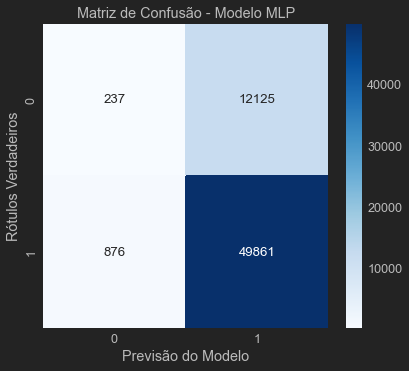

In [109]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Faça previsões com o modelo no conjunto de teste
predictions_mlp = mlp.predict(X_test)
predictions_mlp = (predictions_mlp > 0.5)  # Converter as probabilidades em rótulos binários

# Calcular a matriz de confusão
confusion = confusion_matrix(y_test, predictions_mlp)

# Crie um gráfico da matriz de confusão
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Previsão do Modelo")
plt.ylabel("Rótulos Verdadeiros")
plt.title("Matriz de Confusão - Modelo MLP")
plt.show()

#### MLP com Hyperparametros

In [124]:
from imblearn.over_sampling import SMOTE

# Crie uma instância do SMOTE
smote = SMOTE(random_state=42)

# Aplique o SMOTE aos dados de treinamento
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_over, y_train_over)


In [126]:
print(X_train_balanced.shape), print(y_train_balanced.shape)

(205522, 23)
(205522,)


(None, None)

In [127]:
!pip install imbalanced-learn


In [128]:
# Crie o modelo MLP
model = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, activation=activation, 
                      alpha=alpha, max_iter=max_iter, random_state=42)

# Treine o modelo no conjunto de treinamento balanceado
model.fit(X_train_balanced, y_train_balanced)

# Faça previsões no conjunto de teste
y_pred_mlp2 = model.predict(X_test)

# Calcule as métricas de avaliação
accuracyy_mlp2 = accuracy_score(y_test, y_pred_mlp2)
precision_mlp2 = precision_score(y_test, y_pred_mlp2)
recall_mlp2 = recall_score(y_test, y_pred_mlp2)

# Exiba as métricas
print("Acurácia: {:.2f}".format(accuracyy_mlp2))
print("Precisão: {:.2f}".format(precision_mlp2))
print("Recall: {:.2f}".format(recall_mlp2))


NameError: name 'accuracy_mlp2' is not defined

In [129]:
print("Acurácia: {:.2f}".format(accuracyy_mlp2))
print("Precisão: {:.2f}".format(precision_mlp2))
print("Recall: {:.2f}".format(recall_mlp2))


Acurácia: 0.68
Precisão: 0.83
Recall: 0.76


In [131]:
from sklearn.metrics import confusion_matrix

# Calcular a matriz de confusão
conf_matrix = confusion_matrix(y_test, y_pred_mlp2)

# Exibir a matriz de confusão
print("Matriz de Confusão:")
print(conf_matrix)

Matriz de Confusão:
[[ 4207  8155]
 [12173 38564]]


In [ ]:
Matriz de Confusão:
[[  237 12125]
 [  876 49861]]

### Tabela de Resultados dos Modelos

In [132]:
results_RF = pd.DataFrame(columns=['Modelo', 'Acurácia','Precision', 'Recall'])
results_RF = results_RF.append({'Modelo': 'Model_RandomForest', 'Acurácia': mean_accuracy_rf, 'Precision': mean_precision_rf, 'Recall': mean_recall_rf, 'AUC-ROC': mean_roc_auc_rf}, ignore_index=True)

results_XGB = pd.DataFrame(columns=['Modelo', 'Acurácia','Precision', 'Recall'])
results_XGB = results_XGB.append({'Modelo': 'Model_XGBoost', 'Acurácia': mean_accuracy_xgb, 'Precision': mean_precision_xgb, 'Recall': mean_recall_xgb, 'AUC-ROC': mean_roc_auc_xgb}, ignore_index=True)

results_lgb = pd.DataFrame(columns=['Modelo', 'Acurácia','Precision', 'Recall'])
results_lgb = results_lgb.append({'Modelo': 'Model_LGB', 'Acurácia': mean_accuracy_lgb, 'Precision': mean_precision_lgb, 'Recall': mean_recall_lgb, 'AUC-ROC': mean_roc_auc_lgb}, ignore_index=True)

results_mlp = pd.DataFrame(columns=['Modelo', 'Acurácia','Precision'])
results_mlp = results_mlp.append({'Modelo': 'Model_MLP', 'Acurácia': accuracy, 'Precision': precision, 'Recall': recall}, ignore_index=True)


In [203]:
combined_results = pd.concat([results_RF, results_XGB,results_lgb], ignore_index=True)
combined_results 

,Modelo,Acurácia,Precision,Recall,AUC-ROC
0,Model_RandomForest,0.619268,0.821603,0.612745,0.672659
1,Model_XGBoost,0.793068,0.780203,0.998488,0.746558
2,Model_LGB,0.711799,0.837688,0.751801,0.751528


In [288]:
combined_results = pd.concat([results_RF, results_XGB,results_lgb], ignore_index=True)
combined_results 

,Modelo,Acurácia,Precision,Recall,AUC-ROC
0,Model_RandomForest,0.595992,0.815919,0.578365,0.654035
1,Model_XGBoost,0.772888,0.766168,0.992535,0.729052
2,Model_LGB,0.685876,0.838352,0.707028,0.736208


In [331]:
combined_results = pd.concat([results_RF, results_XGB,results_lgb], ignore_index=True)
combined_results 

,Modelo,Acurácia,Precision,Recall,AUC-ROC
0,Model_RandomForest,0.579267,0.816559,0.548156,0.649538
1,Model_XGBoost,0.770906,0.763589,0.994948,0.727026
2,Model_LGB,0.686247,0.836386,0.710122,0.735157


In [135]:
combined_results = pd.concat([results_RF, results_XGB,results_lgb], ignore_index=True)
combined_results 

,Modelo,Acurácia,Precision,Recall,AUC-ROC
0,Model_RandomForest,0.589860,0.823455,0.559424,0.661003
1,Model_XGBoost,0.800135,0.786565,0.997538,0.759234
2,Model_LGB,0.726581,0.843993,0.768365,0.765529


In [133]:
combined_results = pd.concat([results_RF, results_XGB,results_lgb, results_mlp], ignore_index=True)
combined_results 

,Modelo,Acurácia,Precision,Recall,AUC-ROC
0,Model_RandomForest,0.581983,0.863299,0.568834,0.641297
1,Model_XGBoost,0.802319,0.802888,0.998686,0.658571
2,Model_LGB,0.618327,0.865384,0.620625,0.657704
3,Model_MLP,0.793959,0.804391,0.982734,NaN


### Matriz de Confusão dos Modelos

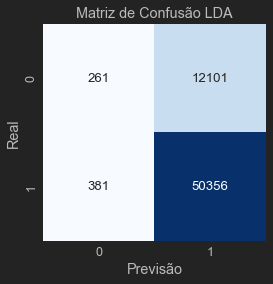

In [161]:
# Matriz de COnfusão do LDA

confusion_lda = confusion_matrix(y_test_lda, y_pred_lda)
plt.figure(figsize=(4, 4))
sns.heatmap(confusion_lda, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Matriz de Confusão LDA")
plt.xlabel("Previsão")
plt.ylabel("Real")
plt.show()

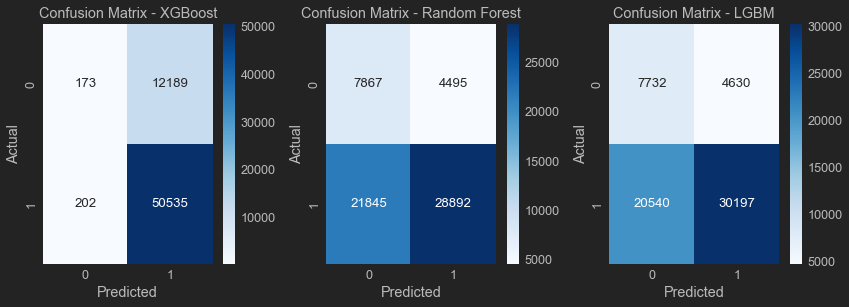

In [134]:
def plot_confusion_matrix_subplot(model, X_test, y_test, title, subplot_position):
    cm = confusion_matrix(y_test, model.predict(X_test))
    plt.subplot(subplot_position)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {title}')
plt.figure(figsize=(12, 8))

plot_confusion_matrix_subplot(model_xgb, X_test, y_test, "XGBoost", 231)
#plot_confusion_matrix_subplot(model_lgb, X_test, y_test, "Decision Tree", 232)
#plot_confusion_matrix_subplot(model_lgb, X_test, y_test, "Logistic Reg", 233)
plot_confusion_matrix_subplot(model_rf, X_test, y_test, "Random Forest", 232)

plot_confusion_matrix_subplot(model_lgb, X_test, y_test, "LGBM", 233)


plt.tight_layout()
plt.show()

In [154]:
from sklearn.metrics import confusion_matrix

# Faça previsões com o modelo no conjunto de teste
predictions_mlp = model_mlp.predict(X_test)
predictions_mlp = (predictions_mlp > 0.5)  # Converter as probabilidades em rótulos binários

# Calcule a matriz de confusão
conf_matrix = confusion_matrix(y_test, predictions_mlp)

# Imprima a matriz de confusão
print("Matriz de Confusão:")
print(conf_matrix)


Matriz de Confusão:
[[  132 12230]
 [  155 50582]]


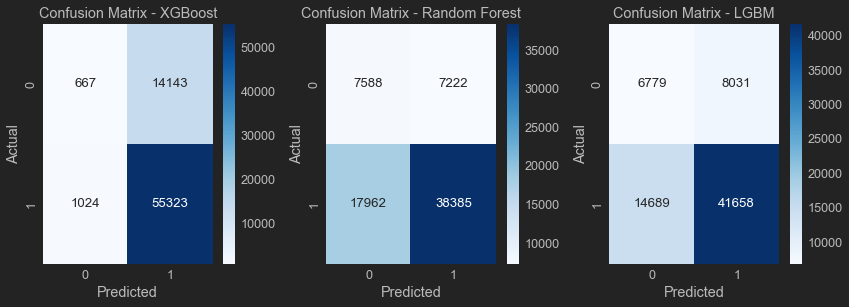

In [289]:
def plot_confusion_matrix_subplot(model, X_test, y_test, title, subplot_position):
    cm = confusion_matrix(y_test, model.predict(X_test))
    plt.subplot(subplot_position)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {title}')
plt.figure(figsize=(12, 8))

plot_confusion_matrix_subplot(model_xgb, X_test, y_test, "XGBoost", 231)
#plot_confusion_matrix_subplot(model_lgb, X_test, y_test, "Decision Tree", 232)
#plot_confusion_matrix_subplot(model_lgb, X_test, y_test, "Logistic Reg", 233)
plot_confusion_matrix_subplot(model_rf, X_test, y_test, "Random Forest", 232)
plot_confusion_matrix_subplot(model_lgb, X_test, y_test, "LGBM", 233)

plt.tight_layout()
plt.show()

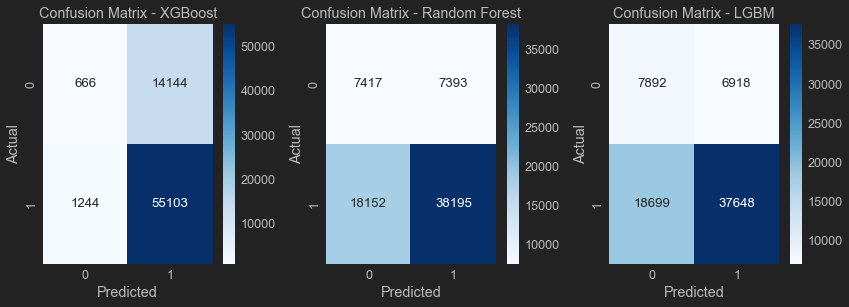

In [332]:
def plot_confusion_matrix_subplot(model, X_test, y_test, title, subplot_position):
    cm = confusion_matrix(y_test, model.predict(X_test))
    plt.subplot(subplot_position)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {title}')
plt.figure(figsize=(12, 8))

plot_confusion_matrix_subplot(model_xgb, X_test, y_test, "XGBoost", 231)
#plot_confusion_matrix_subplot(model_lgb, X_test, y_test, "Decision Tree", 232)
#plot_confusion_matrix_subplot(model_lgb, X_test, y_test, "Logistic Reg", 233)
plot_confusion_matrix_subplot(model_rf, X_test, y_test, "Random Forest", 232)
plot_confusion_matrix_subplot(model_lgb, X_test, y_test, "LGBM", 233)

plt.tight_layout()
plt.show()

#### Explicabilidade do Modelo LightGBM

In [135]:
shap.initjs()
explainer = shap.TreeExplainer(model_lgb)
shap_values = explainer.shap_values(X_train_over)

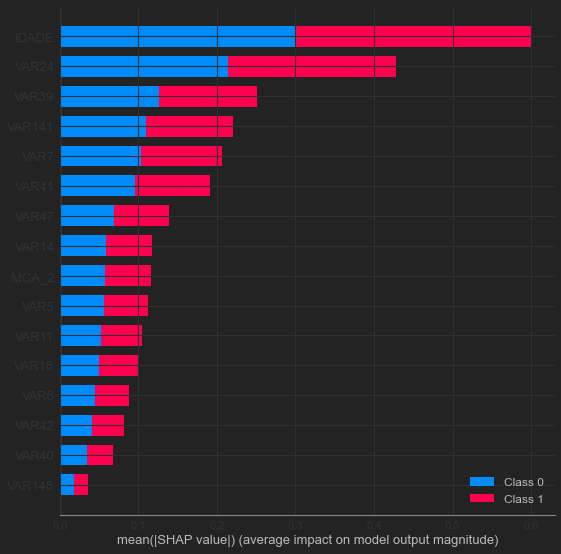

In [334]:
plt.figure(figsize=(15, 10))
shap.summary_plot(shap_values, X_train_over) 

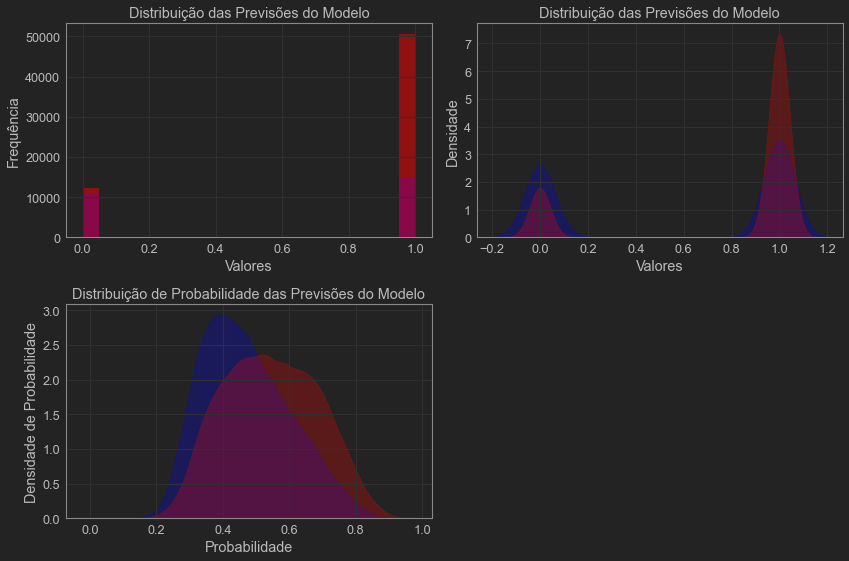

In [136]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.hist(y_pred_lgb, bins=20, alpha=0.5, color='blue', label='Previsões')
plt.hist(y_test, bins=20, alpha=0.5, color='red', label='Valores Reais')
plt.xlabel('Valores')
plt.ylabel('Frequência')
plt.title('Distribuição das Previsões do Modelo')

# Grafico de densidade do modelo
plt.subplot(2, 2, 2)
sns.kdeplot(y_pred_lgb, shade=True, color='blue', label='Previsões')
sns.kdeplot(y_test, shade=True, color='red', label='Valores Reais')
plt.xlabel('Valores')
plt.ylabel('Densidade')
plt.title('Distribuição das Previsões do Modelo')

# Função de Probabilidade do Modelo
y_proba = model_lgb.predict_proba(X_test)

plt.subplot(2, 2, 3)
sns.kdeplot(y_proba[y_test == 0, 1], shade=True, color='blue', label='Probabilidade de Classe 1')
sns.kdeplot(y_proba[y_test == 1, 1], shade=True, color='red', label='Probabilidade de Classe 0')
plt.xlabel('Probabilidade')
plt.ylabel('Densidade de Probabilidade')
plt.title('Distribuição de Probabilidade das Previsões do Modelo')

plt.tight_layout()
plt.show()

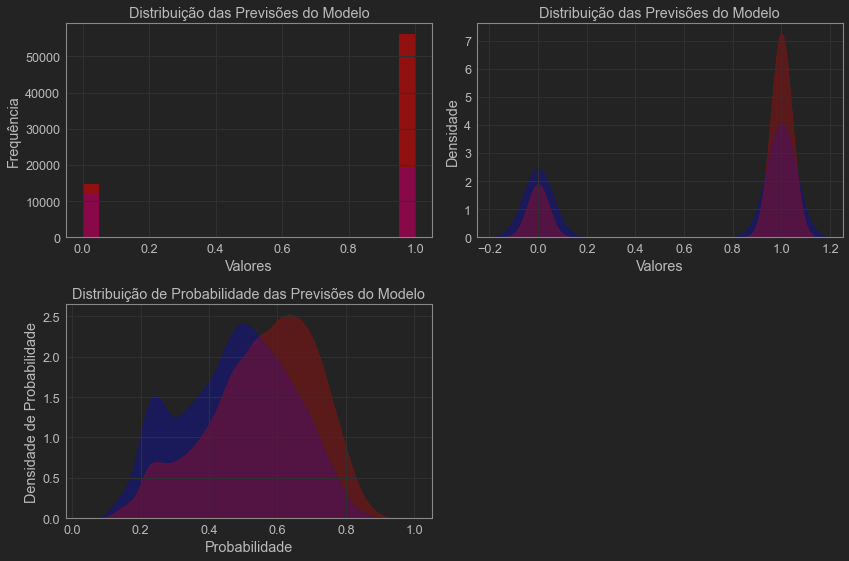

In [335]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.hist(y_pred_lgb, bins=20, alpha=0.5, color='blue', label='Previsões')
plt.hist(y_test, bins=20, alpha=0.5, color='red', label='Valores Reais')
plt.xlabel('Valores')
plt.ylabel('Frequência')
plt.title('Distribuição das Previsões do Modelo')

# Grafico de densidade do modelo
plt.subplot(2, 2, 2)
sns.kdeplot(y_pred_lgb, shade=True, color='blue', label='Previsões')
sns.kdeplot(y_test, shade=True, color='red', label='Valores Reais')
plt.xlabel('Valores')
plt.ylabel('Densidade')
plt.title('Distribuição das Previsões do Modelo')

# Função de Probabilidade do Modelo
y_proba = model_lgb.predict_proba(X_test)

plt.subplot(2, 2, 3)
sns.kdeplot(y_proba[y_test == 0, 1], shade=True, color='blue', label='Probabilidade de Classe 1')
sns.kdeplot(y_proba[y_test == 1, 1], shade=True, color='red', label='Probabilidade de Classe 0')
plt.xlabel('Probabilidade')
plt.ylabel('Densidade de Probabilidade')
plt.title('Distribuição de Probabilidade das Previsões do Modelo')

plt.tight_layout()
plt.show()

#### Teste KS - Distribuição de Prob das Classes

In [137]:
y_proba = model_lgb.predict_proba(X_test)

proba_class_0 = y_proba[y_test == 0, 1]  
proba_class_1 = y_proba[y_test == 1, 1]  

ks_statistic, ks_p_value = ks_2samp(proba_class_0, proba_class_1)

print(f'Estatística KS: {ks_statistic}')
print(f'Valor p: {ks_p_value}')

alpha = 0.05  
if ks_p_value < alpha:
    print('As distribuições são estatisticamente diferentes.')
else:
    print('Não há evidência estatística de diferença nas distribuições.')

Estatística KS: 0.22119985868738096
Valor p: 0.0
As distribuições são estatisticamente diferentes.


In [336]:
y_proba = model_lgb.predict_proba(X_test)

proba_class_0 = y_proba[y_test == 0, 1]  
proba_class_1 = y_proba[y_test == 1, 1]  

ks_statistic, ks_p_value = ks_2samp(proba_class_0, proba_class_1)

print(f'Estatística KS: {ks_statistic}')
print(f'Valor p: {ks_p_value}')

alpha = 0.05  
if ks_p_value < alpha:
    print('As distribuições são estatisticamente diferentes.')
else:
    print('Não há evidência estatística de diferença nas distribuições.')

Estatística KS: 0.21334680337031414
Valor p: 0.0
As distribuições são estatisticamente diferentes.


#### Guardar Modelo

In [138]:
file_name = "credit_score_lgbm_final_mca.bin"
joblib.dump(model_lgb, file_name)

['credit_score_lgbm_final_mca.bin']

## Análise Financeira

Nota: Política de Risco de Crédito Atual = AS-IS.<br>

* Si 'IDADE'<= 28 ===> 'Negado'

Para realizar a análise financeira do seu modelo, suponha que todas as pessoas da base de Teste solicitaram crédito à instituição financeira, na forma de um empréstimo de R$1000,00. Faça o seguinte:

In [142]:
dataframe_treinamento = pd.read_csv('data_base/train.csv')
dataframe_teste = pd.read_csv('data_base/test.csv')

In [143]:
dataframe_teste.shape

(71157, 151)

In [144]:
dataframe_teste =dataframe_teste.query('IDADE<91')
dataframe_teste.shape 

(63099, 151)

### 01. Calcule qual o tamanho da carteira de crédito aprovado (i.e. quanto de dinheiro a Financeira emprestou) na base de Teste, pela Política AS-IS.

In [145]:
emprestimo = 1000
idade_28_menos = dataframe_teste.query('IDADE<29')
idade_28_mais = dataframe_teste.query('IDADE>=29')
print() 
print(f'Política AS-IS')
print(f'---------------------------------------------------')
print(f'A empresa otorga R$.{emprestimo} como empréstimo padrão')
print()
print(f'A nossa carteira conta com {len(idade_28_mais)} clientes')
print()
print(f'A nossa carteira de crédito aprovado é: R$ {len(idade_28_mais)*emprestimo} ')
print(f'---------------------------------------------------')


Política AS-IS
---------------------------------------------------
A empresa otorga R$.1000 como empréstimo padrão

A nossa carteira conta com 48923 clientes

A nossa carteira de crédito aprovado é: R$ 48923000 
---------------------------------------------------


Política AS-IS
A empresa otorga R$.1000 como empréstimo padrão
A nossa carteira conta com 48956 clientes 
A nossa carteira de crédito aprovado é: R$48956000

### 02. Calcule qual a dívida total (suponha que os inadimplentes não pagaram nenhuma parcela do empréstimo), pela Política AS-IS.

In [146]:
adimplente = idade_28_mais.query('TARGET==1')
inadimplente = idade_28_mais.query('TARGET==0')
print()
print(f'Política AS-IS')
print(f'---------------------------------------------------')
print()
print(f'o lucro total é de R$.{len(adimplente)*emprestimo} ')
print(f'A dívida total é de R$.{len(inadimplente)*emprestimo} ')
print()
print(f'Atualmente existem {len(inadimplente)} clientes inadimplentes')
print()
print(f'Atualmente existem {len(adimplente)} clientes nao inadimplentes')

print()
print(f'---------------------------------------------------')


Política AS-IS
---------------------------------------------------

o lucro total é de R$.40447000 
A dívida total é de R$.8476000 

Atualmente existem 8476 clientes inadimplentes

Atualmente existem 40447 clientes nao inadimplentes

---------------------------------------------------


Política AS-IS
o lucro total é de R$.40473000 
A dívida total é de R$.8483000 
Atualmente existem 8483 clientes inadimplentes
Atualmente existem 40473 clientes nao inadimplentes

#### 3.0. Calcule qual o percentual das pessoas da base de Teste que tiveram a solicitação negada. Agora crie um ponto de corte de seu Score que nega o empréstimo para exatamente o mesmo percentual de pessoas (i.e. o empréstimo será negado para quem tiver o Score igual ou superior ao ponto de corte). Essa é a Política TO-BE.

In [178]:
# ASSUMIREMOS QUE OS CLIENTES SEM IDADE TAMBEM SÃO REJEITADOS, ENTÃO INCLUIREI ISSO NO CALCULO.
client_incognita = dataframe_teste[dataframe_teste['IDADE'].isna()]
totalbasese = len(dataframe_teste) - len(client_incognita)
# CALCULO DE PERCENTUAL DE NEGATIVADOS DE EMPRÉSTIMO
percentual_pessoas_negadas = (len(idade_28_menos)*100)/(totalbasese)
percentual_test = (len(idade_28_menos)*100)/len(dataframe_teste)
print(f'Política AS-IS')
print(f'---------------------------------------------------')
print("O Percentual de pessoas Negadas de Empréstimo é: {:.2f} % \n".format(percentual_pessoas_negadas))
print(f'---------------------------------------------------')
print("O Percentual de pessoas Negadas de teste é: {:.2f} % \n".format(percentual_test))

Política AS-IS
---------------------------------------------------
O Percentual de pessoas Negadas de Empréstimo é: 22.47 % 

---------------------------------------------------
O Percentual de pessoas Negadas de teste é: 22.47 % 



Política AS-IS
O Percentual de pessoas Negadas de Empréstimo é: 22.45 % 
O Percentual de pessoas Negadas de teste é: 19.92 % 

In [179]:
len(dataframe_teste) 

63099

In [180]:
client_incognita.shape

(0, 151)

1. Criando um Dataframe para fazer prediçoes

In [181]:
copia_df_testes_1.head()

,REF_DATE,TARGET,VAR2,IDADE,VAR5,VAR6,VAR7,VAR8,VAR9,VAR10,VAR11,VAR14,VAR18,VAR24,VAR39,VAR40,VAR41,VAR42,VAR47,VAR49,VAR50,VAR51,VAR52,VAR53,VAR54,VAR55,VAR56,VAR57,VAR58,VAR59,VAR60,VAR61,VAR62,VAR63,VAR64,VAR65,VAR66,VAR67,VAR68,VAR69,VAR70,VAR71,VAR72,VAR73,VAR74,VAR75,VAR76,VAR77,VAR78,VAR79,VAR80,VAR81,VAR82,VAR83,VAR84,VAR85,VAR86,VAR87,VAR88,VAR89,VAR90,VAR91,VAR92,VAR93,VAR94,VAR95,VAR96,VAR97,VAR98,VAR99,VAR100,VAR101,VAR102,VAR103,VAR104,VAR105,VAR106,VAR107,VAR108,VAR109,VAR110,VAR111,VAR112,VAR113,VAR114,VAR115,VAR116,VAR117,VAR118,VAR119,VAR120,VAR121,VAR122,VAR123,VAR124,VAR125,VAR126,VAR127,VAR128,VAR129,VAR130,VAR131,VAR132,VAR133,VAR134,VAR135,VAR136,VAR137,VAR138,VAR139,VAR140,VAR141,VAR142,VAR147,VAR148,ID,target,score,resultado,resultado_extra,resultado_extra2
0,2017-07-12 00:00:00+00:00,1,M,33.145,SP,-22.434379,-46.930944,OUTROS,E,MEDIA,0.242432,0.156000,1.698630,0.000000,0.598485,0.381619,0.430834,0.611050,1.000,S,S,S,S,N,N,S,S,N,N,N,S,S,N,N,N,S,ALTA,ALTA,MEDIA,ALTA,ALTA,ALTA,ALTA,BAIXISSIMA,ALTA,MEDIA,ALTA,MEDIA,ALTA,ALTA,ALTA,ALTA,BAIXISSIMA,ALTA,BAIXISSIMA,ALTA,MEDIA,ALTA,MEDIA,MEDIA,BAIXISSIMA,ALTA,ALTA,BAIXISSIMA,ALTA,ALTA,MEDIA,ALTISSIMA,MEDIA,MEDIA,BAIXISSIMA,MEDIA,LONGE,MEDIO,LONGE,PROXIMO,MEDIO,MEDIO,MEDIO,LONGE,LONGE,MEDIO,LONGE,LONGE,MEDIO,LONGE,LONGE,LONGE,LONGE,MEDIO,MUITO LONGE,LONGE,LONGE,LONGE,LONGE,MEDIO,LONGE,LONGE,MEDIO,MEDIO,LONGE,LONGE,LONGE,PROXIMO,LONGE,MEDIO,MEDIO,LONGE,MEDIO,LONGE,MEDIO,1852.386339,E,102,EMAIL INEXISTENTE,254563,1,0.300861,0,6,6
1,2017-07-10 00:00:00+00:00,1,F,37.471,PE,-8.875221,-36.366189,E,E,ALTISSIMA,0.000000,0.155000,1.693151,0.000000,0.535474,0.786296,0.877869,0.568515,0.000,S,S,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,MEDIA,MEDIA,BAIXISSIMA,BAIXISSIMA,MEDIA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,MEDIA,BAIXISSIMA,MEDIA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,MEDIA,BAIXISSIMA,MEDIA,BAIXISSIMA,BAIXA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,MEDIA,MEDIA,BAIXISSIMA,BAIXA,BAIXISSIMA,BAIXISSIMA,LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,LONGE,MUITO LONGE,LONGE,LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,LONGE,LONGE,MUITO LONGE,LONGE,MUITO LONGE,MEDIO,MUITO LONGE,LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,LONGE,LONGE,MUITO LONGE,MUITO LONGE,LONGE,LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,LONGE,LONGE,LONGE,LONGE,MUITO LONGE,1548.109828,E,102,EMAIL INEXISTENTE#@#NOME INEXISTENTE#@#CEP INE...,91799,1,0.657926,1,6,6
2,2017-04-01 00:00:00+00:00,1,M,27.827,PA,-4.334255,-49.798835,OUTROS,E,ALTISSIMA,0.242432,0.133997,0.984134,0.060317,0.524659,0.691082,0.964479,0.547769,0.000,S,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,PROXIMO,LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO PROXIMO,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,1570.642421,E,102,EMAIL INEXISTENTE#@#NOME INEXISTENTE#@#CEP INE...,149027,1,0.406622,1,6,6
4,2017-07-12 00:00:00+00:00,1,M,23.263,PA,-1.061619,-46.783011,OUTROS,E,ALTISSIMA,0.242432,0.133997,0.984134,0.060317,0.472500,0.418465,0.936108,0.454868,0.054,S,S,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIM

In [182]:
# Fazendo as previsões em formato de probabilidade 
probs1 = model_lgb.predict_proba(X_test)
#Probabilidades da classe 0
class_0_probs1 = probs1[:, 0]
#Probabilidades da classe 1
class_1_probs1 = probs1[:, 1]

# Criando o Datafreme + Scores
df_predicoes = copia_df_testes_1 # Crio o datafram
df_predicoes['target'] = copia_df_testes_1['TARGET'] # Adiciono Target
df_predicoes['score'] = class_1_probs1 # Adiciono os Scores

In [183]:
df_predicoes.head()

,REF_DATE,TARGET,VAR2,IDADE,VAR5,VAR6,VAR7,VAR8,VAR9,VAR10,VAR11,VAR14,VAR18,VAR24,VAR39,VAR40,VAR41,VAR42,VAR47,VAR49,VAR50,VAR51,VAR52,VAR53,VAR54,VAR55,VAR56,VAR57,VAR58,VAR59,VAR60,VAR61,VAR62,VAR63,VAR64,VAR65,VAR66,VAR67,VAR68,VAR69,VAR70,VAR71,VAR72,VAR73,VAR74,VAR75,VAR76,VAR77,VAR78,VAR79,VAR80,VAR81,VAR82,VAR83,VAR84,VAR85,VAR86,VAR87,VAR88,VAR89,VAR90,VAR91,VAR92,VAR93,VAR94,VAR95,VAR96,VAR97,VAR98,VAR99,VAR100,VAR101,VAR102,VAR103,VAR104,VAR105,VAR106,VAR107,VAR108,VAR109,VAR110,VAR111,VAR112,VAR113,VAR114,VAR115,VAR116,VAR117,VAR118,VAR119,VAR120,VAR121,VAR122,VAR123,VAR124,VAR125,VAR126,VAR127,VAR128,VAR129,VAR130,VAR131,VAR132,VAR133,VAR134,VAR135,VAR136,VAR137,VAR138,VAR139,VAR140,VAR141,VAR142,VAR147,VAR148,ID,target,score,resultado,resultado_extra,resultado_extra2
0,2017-07-12 00:00:00+00:00,1,M,33.145,SP,-22.434379,-46.930944,OUTROS,E,MEDIA,0.242432,0.156000,1.698630,0.000000,0.598485,0.381619,0.430834,0.611050,1.000,S,S,S,S,N,N,S,S,N,N,N,S,S,N,N,N,S,ALTA,ALTA,MEDIA,ALTA,ALTA,ALTA,ALTA,BAIXISSIMA,ALTA,MEDIA,ALTA,MEDIA,ALTA,ALTA,ALTA,ALTA,BAIXISSIMA,ALTA,BAIXISSIMA,ALTA,MEDIA,ALTA,MEDIA,MEDIA,BAIXISSIMA,ALTA,ALTA,BAIXISSIMA,ALTA,ALTA,MEDIA,ALTISSIMA,MEDIA,MEDIA,BAIXISSIMA,MEDIA,LONGE,MEDIO,LONGE,PROXIMO,MEDIO,MEDIO,MEDIO,LONGE,LONGE,MEDIO,LONGE,LONGE,MEDIO,LONGE,LONGE,LONGE,LONGE,MEDIO,MUITO LONGE,LONGE,LONGE,LONGE,LONGE,MEDIO,LONGE,LONGE,MEDIO,MEDIO,LONGE,LONGE,LONGE,PROXIMO,LONGE,MEDIO,MEDIO,LONGE,MEDIO,LONGE,MEDIO,1852.386339,E,102,EMAIL INEXISTENTE,254563,1,0.300861,0,6,6
1,2017-07-10 00:00:00+00:00,1,F,37.471,PE,-8.875221,-36.366189,E,E,ALTISSIMA,0.000000,0.155000,1.693151,0.000000,0.535474,0.786296,0.877869,0.568515,0.000,S,S,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,MEDIA,MEDIA,BAIXISSIMA,BAIXISSIMA,MEDIA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,MEDIA,BAIXISSIMA,MEDIA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,MEDIA,BAIXISSIMA,MEDIA,BAIXISSIMA,BAIXA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,MEDIA,MEDIA,BAIXISSIMA,BAIXA,BAIXISSIMA,BAIXISSIMA,LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,LONGE,MUITO LONGE,LONGE,LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,LONGE,LONGE,MUITO LONGE,LONGE,MUITO LONGE,MEDIO,MUITO LONGE,LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,LONGE,LONGE,MUITO LONGE,MUITO LONGE,LONGE,LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,LONGE,LONGE,LONGE,LONGE,MUITO LONGE,1548.109828,E,102,EMAIL INEXISTENTE#@#NOME INEXISTENTE#@#CEP INE...,91799,1,0.657926,1,6,6
2,2017-04-01 00:00:00+00:00,1,M,27.827,PA,-4.334255,-49.798835,OUTROS,E,ALTISSIMA,0.242432,0.133997,0.984134,0.060317,0.524659,0.691082,0.964479,0.547769,0.000,S,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,PROXIMO,LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO PROXIMO,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,1570.642421,E,102,EMAIL INEXISTENTE#@#NOME INEXISTENTE#@#CEP INE...,149027,1,0.406622,1,6,6
4,2017-07-12 00:00:00+00:00,1,M,23.263,PA,-1.061619,-46.783011,OUTROS,E,ALTISSIMA,0.242432,0.133997,0.984134,0.060317,0.472500,0.418465,0.936108,0.454868,0.054,S,S,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIM

In [184]:

df_best_performarnce = df_predicoes[['TARGET','score']]
df_best_performarnce

,TARGET,score
0,1,0.300861
1,1,0.657926
2,1,0.406622
4,1,0.327082
5,1,0.636084
...,...,...
71151,1,0.559050
71152,1,0.326601
71154,1,0.361573
71155,1,0.332984


In [185]:
df_best_performarnce.to_csv('df_best_performarnce',index=False)

In [186]:
df_predicoes.shape

(63099, 121)

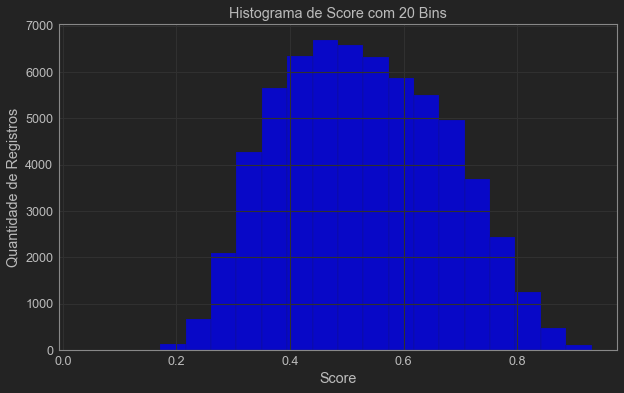

In [187]:
import seaborn as sns
import matplotlib.pyplot as plt

# Suponha que 'df' seja o seu DataFrame com a coluna 'pontos'
# Defina o número de bins desejado
num_bins = 20

# Crie um gráfico de barras com base na coluna 'pontos'
plt.figure(figsize=(10, 6))
sns.histplot(data=df_predicoes, x='score', bins=num_bins, kde=False, color='blue')

# Configuração de rótulos e título
plt.xlabel('Score')
plt.ylabel('Quantidade de Registros')
plt.title(f'Histograma de Score com {num_bins} Bins')

plt.show()

In [188]:
# Certifique-se de que a coluna 'Date' seja tratada como uma data
df_predicoes['REF_DATE'] = pd.to_datetime(df_predicoes['REF_DATE'])


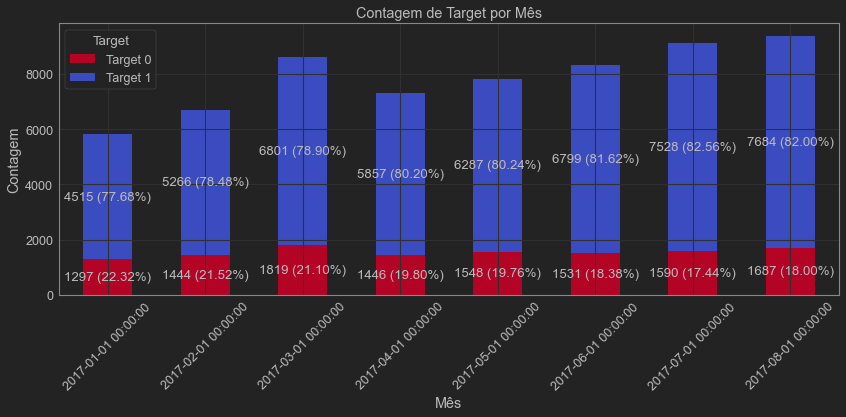

In [189]:

# Certifique-se de que a coluna 'REF_DATE' seja tratada como uma data
df_predicoes['REF_DATE'] = pd.to_datetime(df_predicoes['REF_DATE'])

# Crie um DataFrame com duas colunas para cada mês (uma para target=0 e outra para target=1)
monthly_counts = df_predicoes.groupby([df_predicoes['REF_DATE'].dt.to_period("M"), 'target']).size().unstack(fill_value=0)

# Converta os períodos de volta para objetos datetime
monthly_counts.index = monthly_counts.index.to_timestamp()

# Crie o gráfico de barras empilhadas
plt.figure(figsize=(12, 6))
#ax = monthly_counts.plot(kind='bar', stacked=True, colormap='coolwarm', ax=plt.gca())
ax = monthly_counts.plot(kind='bar', stacked=True, colormap='coolwarm_r', ax=plt.gca())


plt.title('Contagem de Target por Mês')
plt.xlabel('Mês')
plt.ylabel('Contagem')
plt.xticks(rotation=45)
plt.legend(title='Target', labels=['Target 0', 'Target 1'])

# Adicione as porcentagens como rótulos nas barras
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    if height > 0:
        ax.annotate(f'{height:.0f} ({height/sum(p.get_height() for p in ax.patches if p.get_x() == x):.2%})', (x + width/2, y + height/2), ha='center', va='center')

plt.tight_layout()

# Exiba o gráfico
plt.show()


2. Criando pontos de corte:

In [190]:
maior_40 = df_predicoes.query('score>=0.40')
maior_40p5 = df_predicoes.query('score>=0.405')
maior_41 = df_predicoes.query('score>=0.41')
maior_41p5 = df_predicoes.query('score>=0.415')
maior_45 = df_predicoes.query('score>=0.45')
maior_50 = df_predicoes.query('score>=0.5')
maior_55 = df_predicoes.query('score>=0.55')
maior_60 = df_predicoes.query('score>=0.60')

print(f'Percentual Empréstimo Negado pela Politica TO-BE')
print()
print(f'---------------------------------------------------')
print()
print("Com CORTE 40%: {:.2f}  \n".format(len(maior_40)))
print(f'---------------------------------------------------')
print("Com CORTE 40.5%: {:.2f}  \n".format(len(maior_40p5)))
print(f'---------------------------------------------------')
print("Com CORTE 41%: {:.2f}  \n".format(len(maior_41)))
print(f'---------------------------------------------------')
print("Com CORTE 41.5%: {:.2f}  \n".format(len(maior_41p5)))
print(f'---------------------------------------------------')
print("Com CORTE 45%: {:.2f}  \n".format(len(maior_45)))
print(f'---------------------------------------------------')
print("Com CORTE 50%: {:.2f}  \n".format(len(maior_50)))
print(f'---------------------------------------------------')
print("Com CORTE 55%: {:.2f}  \n".format(len(maior_55)))
print(f'---------------------------------------------------')
print("Com CORTE 60%: {:.2f}  \n".format(len(maior_60)))
print(f'---------------------------------------------------')

Percentual Empréstimo Negado pela Politica TO-BE

---------------------------------------------------

Com CORTE 40%: 49567.00  

---------------------------------------------------
Com CORTE 40.5%: 48850.00  

---------------------------------------------------
Com CORTE 41%: 48154.00  

---------------------------------------------------
Com CORTE 41.5%: 47457.00  

---------------------------------------------------
Com CORTE 45%: 42345.00  

---------------------------------------------------
Com CORTE 50%: 34827.00  

---------------------------------------------------
Com CORTE 55%: 27469.00  

---------------------------------------------------
Com CORTE 60%: 20705.00  

---------------------------------------------------


Com a Política TO-BE, para poder ter o mesmo percentual de 22.5% aprox de solicitações de Empréstimo Negadas dado pela Política antiga. <br>Devemos fazer o CORTE em 40% aprox . Menor que esse Score, deve ser negado o crédito.

In [169]:
#epsilon = 1e-6  # Pequena margem de erro para comparação de números de ponto flutuante

#df_predicoes['resultado_extra2'] = df_predicoes['score'].apply(lambda x: 7 if (0.4 - epsilon < x < 0.405 + epsilon) else 6)

In [176]:
#xy1 = df_predicoes.query('(resultado_extra2==7) & (TARGET==1)')
#xy0 = df_predicoes.query('(resultado_extra2==7) & (TARGET==0)')

In [177]:
#print(xy1.shape), print(xy0.shape)

(527, 121)
(190, 121)


(None, None)

In [174]:
#df_predicoes

,REF_DATE,TARGET,VAR2,IDADE,VAR5,VAR6,VAR7,VAR8,VAR9,VAR10,VAR11,VAR14,VAR18,VAR24,VAR39,VAR40,VAR41,VAR42,VAR47,VAR49,VAR50,VAR51,VAR52,VAR53,VAR54,VAR55,VAR56,VAR57,VAR58,VAR59,VAR60,VAR61,VAR62,VAR63,VAR64,VAR65,VAR66,VAR67,VAR68,VAR69,VAR70,VAR71,VAR72,VAR73,VAR74,VAR75,VAR76,VAR77,VAR78,VAR79,VAR80,VAR81,VAR82,VAR83,VAR84,VAR85,VAR86,VAR87,VAR88,VAR89,VAR90,VAR91,VAR92,VAR93,VAR94,VAR95,VAR96,VAR97,VAR98,VAR99,VAR100,VAR101,VAR102,VAR103,VAR104,VAR105,VAR106,VAR107,VAR108,VAR109,VAR110,VAR111,VAR112,VAR113,VAR114,VAR115,VAR116,VAR117,VAR118,VAR119,VAR120,VAR121,VAR122,VAR123,VAR124,VAR125,VAR126,VAR127,VAR128,VAR129,VAR130,VAR131,VAR132,VAR133,VAR134,VAR135,VAR136,VAR137,VAR138,VAR139,VAR140,VAR141,VAR142,VAR147,VAR148,ID,target,score,resultado,resultado_extra,resultado_extra2
0,2017-07-12 00:00:00+00:00,1,M,33.145,SP,-22.434379,-46.930944,OUTROS,E,MEDIA,0.242432,0.156000,1.698630,0.000000,0.598485,0.381619,0.430834,0.611050,1.000,S,S,S,S,N,N,S,S,N,N,N,S,S,N,N,N,S,ALTA,ALTA,MEDIA,ALTA,ALTA,ALTA,ALTA,BAIXISSIMA,ALTA,MEDIA,ALTA,MEDIA,ALTA,ALTA,ALTA,ALTA,BAIXISSIMA,ALTA,BAIXISSIMA,ALTA,MEDIA,ALTA,MEDIA,MEDIA,BAIXISSIMA,ALTA,ALTA,BAIXISSIMA,ALTA,ALTA,MEDIA,ALTISSIMA,MEDIA,MEDIA,BAIXISSIMA,MEDIA,LONGE,MEDIO,LONGE,PROXIMO,MEDIO,MEDIO,MEDIO,LONGE,LONGE,MEDIO,LONGE,LONGE,MEDIO,LONGE,LONGE,LONGE,LONGE,MEDIO,MUITO LONGE,LONGE,LONGE,LONGE,LONGE,MEDIO,LONGE,LONGE,MEDIO,MEDIO,LONGE,LONGE,LONGE,PROXIMO,LONGE,MEDIO,MEDIO,LONGE,MEDIO,LONGE,MEDIO,1852.386339,E,102,EMAIL INEXISTENTE,254563,1,0.300861,0,6,6
1,2017-07-10 00:00:00+00:00,1,F,37.471,PE,-8.875221,-36.366189,E,E,ALTISSIMA,0.000000,0.155000,1.693151,0.000000,0.535474,0.786296,0.877869,0.568515,0.000,S,S,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,MEDIA,MEDIA,BAIXISSIMA,BAIXISSIMA,MEDIA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,MEDIA,BAIXISSIMA,MEDIA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,MEDIA,BAIXISSIMA,MEDIA,BAIXISSIMA,BAIXA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,MEDIA,MEDIA,BAIXISSIMA,BAIXA,BAIXISSIMA,BAIXISSIMA,LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,LONGE,MUITO LONGE,LONGE,LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,LONGE,LONGE,MUITO LONGE,LONGE,MUITO LONGE,MEDIO,MUITO LONGE,LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,LONGE,LONGE,MUITO LONGE,MUITO LONGE,LONGE,LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,LONGE,LONGE,LONGE,LONGE,MUITO LONGE,1548.109828,E,102,EMAIL INEXISTENTE#@#NOME INEXISTENTE#@#CEP INE...,91799,1,0.657926,1,6,6
2,2017-04-01 00:00:00+00:00,1,M,27.827,PA,-4.334255,-49.798835,OUTROS,E,ALTISSIMA,0.242432,0.133997,0.984134,0.060317,0.524659,0.691082,0.964479,0.547769,0.000,S,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,PROXIMO,LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO PROXIMO,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,1570.642421,E,102,EMAIL INEXISTENTE#@#NOME INEXISTENTE#@#CEP INE...,149027,1,0.406622,1,6,6
4,2017-07-12 00:00:00+00:00,1,M,23.263,PA,-1.061619,-46.783011,OUTROS,E,ALTISSIMA,0.242432,0.133997,0.984134,0.060317,0.472500,0.418465,0.936108,0.454868,0.054,S,S,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIM

In [199]:
epsilon = 1e-6  # Pequena margem de erro para comparação de números de ponto flutuante

df_predicoes['resultado'] = df_predicoes['score'].apply(lambda x: 0 if (x < 0.40 + epsilon) else 1)

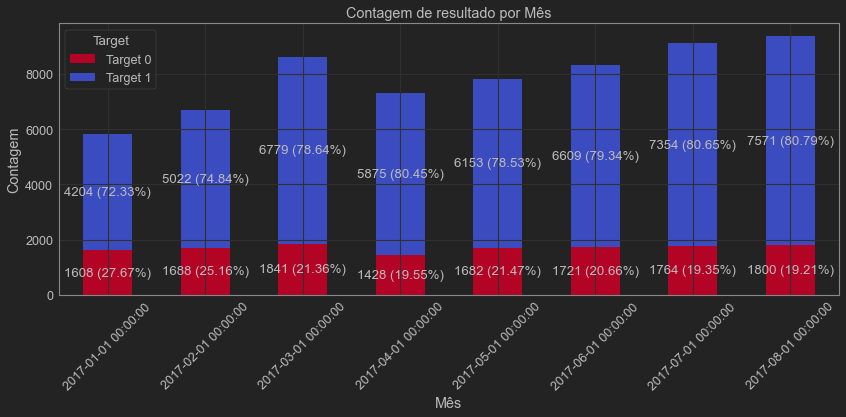

In [200]:

df_predicoes['REF_DATE'] = pd.to_datetime(df_predicoes['REF_DATE'])

monthly_counts = df_predicoes.groupby([df_predicoes['REF_DATE'].dt.to_period("M"), 'resultado']).size().unstack(fill_value=0)

# Converta os períodos de volta para objetos datetime
monthly_counts.index = monthly_counts.index.to_timestamp()

plt.figure(figsize=(12, 6))
#ax = monthly_counts.plot(kind='bar', stacked=True, colormap='coolwarm', ax=plt.gca())
ax = monthly_counts.plot(kind='bar', stacked=True, colormap='coolwarm_r', ax=plt.gca())
plt.title('Contagem de resultado por Mês')
plt.xlabel('Mês')
plt.ylabel('Contagem')
plt.xticks(rotation=45)
plt.legend(title='Target', labels=['Target 0', 'Target 1'])

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    if height > 0:
        ax.annotate(f'{height:.0f} ({height/sum(p.get_height() for p in ax.patches if p.get_x() == x):.2%})', (x + width/2, y + height/2), ha='center', va='center')

plt.tight_layout()
plt.show()

In [201]:
df_predicoes.head(10)

,REF_DATE,TARGET,VAR2,IDADE,VAR5,VAR6,VAR7,VAR8,VAR9,VAR10,VAR11,VAR14,VAR18,VAR24,VAR39,VAR40,VAR41,VAR42,VAR47,VAR49,VAR50,VAR51,VAR52,VAR53,VAR54,VAR55,VAR56,VAR57,VAR58,VAR59,VAR60,VAR61,VAR62,VAR63,VAR64,VAR65,VAR66,VAR67,VAR68,VAR69,VAR70,VAR71,VAR72,VAR73,VAR74,VAR75,VAR76,VAR77,VAR78,VAR79,VAR80,VAR81,VAR82,VAR83,VAR84,VAR85,VAR86,VAR87,VAR88,VAR89,VAR90,VAR91,VAR92,VAR93,VAR94,VAR95,VAR96,VAR97,VAR98,VAR99,VAR100,VAR101,VAR102,VAR103,VAR104,VAR105,VAR106,VAR107,VAR108,VAR109,VAR110,VAR111,VAR112,VAR113,VAR114,VAR115,VAR116,VAR117,VAR118,VAR119,VAR120,VAR121,VAR122,VAR123,VAR124,VAR125,VAR126,VAR127,VAR128,VAR129,VAR130,VAR131,VAR132,VAR133,VAR134,VAR135,VAR136,VAR137,VAR138,VAR139,VAR140,VAR141,VAR142,VAR147,VAR148,ID,target,score,resultado,resultado_extra,resultado_extra2
0,2017-07-12 00:00:00+00:00,1,M,33.145,SP,-22.434379,-46.930944,OUTROS,E,MEDIA,0.242432,0.156000,1.698630,0.000000,0.598485,0.381619,0.430834,0.611050,1.000,S,S,S,S,N,N,S,S,N,N,N,S,S,N,N,N,S,ALTA,ALTA,MEDIA,ALTA,ALTA,ALTA,ALTA,BAIXISSIMA,ALTA,MEDIA,ALTA,MEDIA,ALTA,ALTA,ALTA,ALTA,BAIXISSIMA,ALTA,BAIXISSIMA,ALTA,MEDIA,ALTA,MEDIA,MEDIA,BAIXISSIMA,ALTA,ALTA,BAIXISSIMA,ALTA,ALTA,MEDIA,ALTISSIMA,MEDIA,MEDIA,BAIXISSIMA,MEDIA,LONGE,MEDIO,LONGE,PROXIMO,MEDIO,MEDIO,MEDIO,LONGE,LONGE,MEDIO,LONGE,LONGE,MEDIO,LONGE,LONGE,LONGE,LONGE,MEDIO,MUITO LONGE,LONGE,LONGE,LONGE,LONGE,MEDIO,LONGE,LONGE,MEDIO,MEDIO,LONGE,LONGE,LONGE,PROXIMO,LONGE,MEDIO,MEDIO,LONGE,MEDIO,LONGE,MEDIO,1852.386339,E,102,EMAIL INEXISTENTE,254563,1,0.300861,0,6,6
1,2017-07-10 00:00:00+00:00,1,F,37.471,PE,-8.875221,-36.366189,E,E,ALTISSIMA,0.000000,0.155000,1.693151,0.000000,0.535474,0.786296,0.877869,0.568515,0.000,S,S,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,MEDIA,MEDIA,BAIXISSIMA,BAIXISSIMA,MEDIA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,MEDIA,BAIXISSIMA,MEDIA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,MEDIA,BAIXISSIMA,MEDIA,BAIXISSIMA,BAIXA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,MEDIA,MEDIA,BAIXISSIMA,BAIXA,BAIXISSIMA,BAIXISSIMA,LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,LONGE,MUITO LONGE,LONGE,LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,LONGE,LONGE,MUITO LONGE,LONGE,MUITO LONGE,MEDIO,MUITO LONGE,LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,LONGE,LONGE,MUITO LONGE,MUITO LONGE,LONGE,LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,LONGE,LONGE,LONGE,LONGE,MUITO LONGE,1548.109828,E,102,EMAIL INEXISTENTE#@#NOME INEXISTENTE#@#CEP INE...,91799,1,0.657926,1,6,6
2,2017-04-01 00:00:00+00:00,1,M,27.827,PA,-4.334255,-49.798835,OUTROS,E,ALTISSIMA,0.242432,0.133997,0.984134,0.060317,0.524659,0.691082,0.964479,0.547769,0.000,S,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,PROXIMO,LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO PROXIMO,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,MUITO LONGE,1570.642421,E,102,EMAIL INEXISTENTE#@#NOME INEXISTENTE#@#CEP INE...,149027,1,0.406622,1,6,6
4,2017-07-12 00:00:00+00:00,1,M,23.263,PA,-1.061619,-46.783011,OUTROS,E,ALTISSIMA,0.242432,0.133997,0.984134,0.060317,0.472500,0.418465,0.936108,0.454868,0.054,S,S,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,BAIXISSIM

In [202]:
emprestimos_feitos = df_predicoes.query('resultado==1')
len(emprestimos_feitos) 

49567

In [203]:
bom_pagador = emprestimos_feitos.query('TARGET==1')
mal_pagador =emprestimos_feitos.query('TARGET==0')


In [204]:
print()
print(f'Política NOVA')
print(f'---------------------------------------------------')
print(f'O tamaño da carteira é: {len(emprestimos_feitos)} ')
print(f'O total de crédito é: {len(emprestimos_feitos)* 1000} ')
print()
print(f'o lucro total é de R$ {len(bom_pagador)*emprestimo} ')
print(f'A dívida total é de R$ {len(mal_pagador)*emprestimo} ')
print()
print(f'Atualmente existem {len(bom_pagador)} clientes bom pagador')
print()
print(f'Atualmente existem {len(mal_pagador)} clientes inadimplentes')

print()
print(f'---------------------------------------------------')


Política NOVA
---------------------------------------------------
O tamaño da carteira é: 49567 
O total de crédito é: 49567000 

o lucro total é de R$ 41523000 
A dívida total é de R$ 8044000 

Atualmente existem 41523 clientes bom pagador

Atualmente existem 8044 clientes inadimplentes

---------------------------------------------------


Incrementariamos a nossa base de crédito, assumindo mais risco!
Naturalmente, Incrementariamos os inadimplentes em x%
Incrementariamos a nossa receita em x% 
No global estamos ganhando mais dinheiro do que perdendo.
Recomendamos assumir esse risco e maximizar o lucro.

Análise FInanceira:
* Incrementamos a carteira em 1.31%
* Aumentamos os lucros em 1.4%
* Reduzimos as dvídivas em 1.3% 

Apesar de termos enfrentado um desafio significativo, assumindo o risco de incrementar o capital de empréstimo, conseguimos um retorno positivo. 


[LightGBM] [Info] Number of positive: 9110, number of negative: 2447
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001184 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3033
[LightGBM] [Info] Number of data points in the train set: 11557, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 29688, number of negative: 7873
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002246 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3053
[LightGBM] [Info] Number of data points in the train set: 37561, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Inf

[LightGBM] [Info] Number of positive: 50291, number of negative: 13275
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000761 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3059
[LightGBM] [Info] Number of data points in the train set: 63566, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 70886, number of negative: 18684
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003616 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 89570, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[L

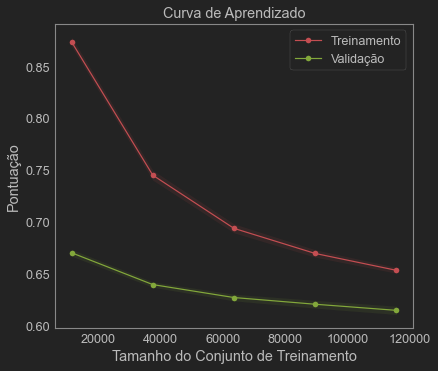

In [371]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

# Crie uma função para plotar a curva de aprendizado
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Tamanho do Conjunto de Treinamento")
    plt.ylabel("Pontuação")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Treinamento")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Validação")

    plt.legend(loc="best")
    return plt

# Use a função plot_learning_curve para criar a curva de aprendizado
plot_learning_curve(model_lgb, "Curva de Aprendizado", X_train, y_train, cv=5)
plt.show()


Nota: Como desafios para próximos passos poderia aprofundar mais no estudo de correlações entre as variáveis. Já que mostraranse de uma  